# Model
##### Amy Ma

In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.decomposition import FastICA
import sklearn.linear_model as lm
import statsmodels.api as sm

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics,preprocessing,cross_validation
from statsmodels.tsa.stattools import adfuller
from pandas.tools.plotting import autocorrelation_plot
from sklearn.ensemble import GradientBoostingRegressor

Using TensorFlow backend.


## Introduction
<img src="model_structure.png">, 

## Functions

In [2]:
# define a function to import datasets
'''
Define a function to read all the dataset:
    1.source = the data folder
    2.dataname = the file name
    3.date = the date column
''' 
def read_adj(source,dataname,date):
    # define a function to parse the date
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    # give path
    path = source+dataname
    # read and save the data 
    data = pd.read_csv(path,parse_dates=[date], date_parser=dateparse) 
    data = data.set_index(date)
    # sort data by datatime index
    data = data.sort_index()
    print "Basic information of "+dataname+":"
    print data.head() # to see the data
    print "*" *100
    print data.describe() # summary the data
    return data
def read_tweet(source,dataname,date):
    # define a function to parse the date
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
    # give path
    path = source+dataname
    # read and save the data 
    data = pd.read_csv(path,parse_dates=[date], date_parser=dateparse) 
    #data = data.set_index(date)
    # sort data by datatime index
    data = data.sort_index()
    print "Basic information of "+dataname+":"
    print data.head() # to see the data
    print "*" *100
    print data.describe() # summary the data
    print "*" *100
    return data


In [3]:
# define a function to give daily returns
'''
This function will take a DataFrame with adjuseted close price, 
and return a DataFrame with daily returns.
For dsk, we also account for corporate action
1. adj_close = adjusted close price
2. ca = corporation action
'''
def get_returns(adj_close, ca=None):
    if ca is None:
        # color is not None
        return adj_close.diff()/adj_close.shift(1)
    else: 
        return (adj_close.diff()+ca)/adj_close.shift(1)
def merge_tweet(data1,data2,label):
    data2 = pd.DataFrame(data1).merge(data2, how='left', right_index=True, left_index=True)
    data2.fillna(0,inplace=True)# fill na=0
    data2 = data2[label]
    return pd.DataFrame(data2)    

In [4]:
# define a function to plot the returns
'''
This function will make a gerneral plot for returns
1. returns1,returns2 = company's returns
2. width,height = the size of the graph
'''
def plot_return(returns1,name1,returns2,name2,width,height,color1,color2):
    fig = plt.figure()
    fig.set_size_inches(width,height)
    # put together
    ax1 = fig.add_subplot(211)
    ax1.set_title('Combined plot', fontsize=20)
    ax1.plot(returns1, color1)
    ax1.plot(returns2, color2)
    # separate
    ax2 = fig.add_subplot(223)
    ax2.set_title(name1, fontsize=20)
    ax2.plot(returns1, color1)

    ax3 = fig.add_subplot(224)
    ax3.set_title(name2, fontsize=20)
    ax3.plot(returns2, color2)
    #fig, ax = plt.subplots()
    #fig.set_size_inches(width,height)
    #plt.plot(cab_returns,color=color)

def plot_tweets(data1,data2,return1,return2,label):
    a = scale_01(data1)
    b = scale_01(data2)
    fig = plt.figure()
    fig.set_size_inches(18,15)
    # put together
    ax1 = fig.add_subplot(221)
    title = 'Returns vs. ' +label+'(CAB)'
    ax1.set_title(title, fontsize=20)
    ax1.plot(cab, "black")
    ax1.plot(a,"blue")
    # separate
    ax2 = fig.add_subplot(222)
    title = 'Returns vs. ' +label+'(DKS)'
    ax2.set_title(title, fontsize=20)
    ax2.plot(cab, "black")
    ax2.plot(b,"green")

In [5]:
def get_ICA(data,n_comps=3,plot=False):
    #result = pd.concat(frame, axis=1)
    #result = data
    #X=result.values
    X = data
    #X = (X-X.mean())#/X.std(ddof=0)
    ica = FastICA(n_components=n_comps)
    S_ = ica.fit_transform(X)  # Reconstruct signals
    A_ = ica.mixing_  # Get estimated mixing matrix
    ICs = pd.DataFrame({"c1":S_[:,0],'c2':S_[:,1],'c3':S_[:,2]})
    # Make plots to see the signal
    if plot==True:
        fig=plt.figure()
        fig.set_size_inches(18,16)
        models = [S_]
        names = ['ICA recovered signals']
        colors = range(0,n_comps)
        for ii, (model, name) in enumerate(zip(models, names), 1):
            plt.subplot(2, 1, ii)
            plt.title(name)
            for sig, color in zip(model.T, colors):
                plt.plot(sig, color=color)
        plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
        plt.show()
    return ICs



In [6]:
def crosscorr(data1, data2, start, end, name):
    dict_for_df = {}
    for i in range(start,end):   
        lag = i
        corr = data1.corr(data2.shift(lag)) 
        dict_for_df[i] = [corr]     # store in a dict
    df = pd.DataFrame(dict_for_df).T # after the loop convert the dict to a dataframe
    df.columns = name
    # make a plot 
    plt.plot(df)
    plt.show()
    return df

def leadlag_corr_ic(data1,data2,start,end,threshold):
    df = data1.reset_index(drop=True)
    # component1
    cr1 = crosscorr(df,data2["c1"],0,30,["corr1"])
    print ("For compenent1 use lag = ")
    print cr1[cr1["corr1"]>threshold]
    # component2
    cr2 = crosscorr(df,data2["c2"],0,30,["corr2"])
    #cr2 = cr2.reindex(cr2.abs().sort_values(["corr2"],inplace=False,ascending= False).index).T.iloc[0,0:n_show]
    print "For compenent2 use lag = " 
    print cr2[cr2["corr2"]>threshold]
    # component3
    cr3 = crosscorr(df,data2["c3"],0,30,["corr3"])
    #cr3 = cr3.reindex(cr3.abs().sort_values(["corr3"],inplace=False,ascending= False).index).T.iloc[0,0:n_show]
    print "For compenent3 use lag = " 
    print cr3[cr3["corr3"]>threshold]
    c1 = cr1[cr1["corr1"]>threshold].index.values
    c2 = cr2[cr2["corr2"]>threshold].index.values
    c3 = cr3[cr3["corr3"]>threshold].index.values
    return c1,c2,c3

def leadlag_corr(data1,data2_frame,start,end,threshold):
    df = data1.reset_index(drop=True)
    data2 = pd.concat(data2_frame, axis=1).reset_index(drop=True)
#     lag = []
#     def print_leadlag(col):
#         data = crosscorr(df,data2.iloc[:,col],0,30,[col])
#         print "For "+col+ "use lag = " 
#         print data[data[label.abs()]>threshold]
#         corr= data[data[label.abs()]>threshold].index.values
#         return corr
#     for i in range(1,data2.shape[1]+1):
#         lag.append(print_leadlag(col="data"))
# data1
    cr1 = crosscorr(df,data2.iloc[:,0],0,30,["corr1"])
    print ("For dataset1 use lag = ")
    print cr1[cr1["corr1"].abs()>threshold]
    # data2
    cr2 = crosscorr(df,data2.iloc[:,1],0,30,["corr2"])
    #cr2 = cr2.reindex(cr2.abs().sort_values(["corr2"],inplace=False,ascending= False).index).T.iloc[0,0:n_show]
    print "For dataset2 use lag = " 
    print cr2[cr2["corr2"].abs()>threshold]
    # data3
    cr3 = crosscorr(df,data2.iloc[:,2],0,30,["corr3"])
    #cr3 = cr3.reindex(cr3.abs().sort_values(["corr3"],inplace=False,ascending= False).index).T.iloc[0,0:n_show]
    print "For dataset3 use lag = " 
    print cr3[cr3["corr3"].abs()>threshold]
    # data4
    cr4 = crosscorr(df,data2.iloc[:,3],0,30,["corr4"])
    print "For dataset4 use lag = " 
    print cr4[cr4["corr4"].abs()>threshold]
    # data5
    cr5 = crosscorr(df,data2.iloc[:,4],0,30,["corr5"])
    print "For dataset5 use lag = " 
    print cr5[cr5["corr5"].abs()>threshold]
#     # data6
#     cr6 = crosscorr(df,data2.iloc[:,4],0,30,["corr6"])
#     print "For dataset6 use lag = " 
#     print cr6[cr6["corr6"].abs()>threshold]
#     # data7
#     cr7 = crosscorr(df,data2.iloc[:,4],0,30,["corr7"])
#     print "For dataset7 use lag = " 
#     print cr7[cr7["corr7"].abs()>threshold]
#     # data8
#     cr8 = crosscorr(df,data2.iloc[:,4],0,30,["corr8"])
#     print "For dataset8 use lag = " 
#     print cr8[cr8["corr8"].abs()>threshold]
    c1 = cr1[cr1["corr1"].abs()>threshold].index.values
    c2 = cr2[cr2["corr2"].abs()>threshold].index.values
    c3 = cr3[cr3["corr3"].abs()>threshold].index.values
    c4 = cr4[cr4["corr4"].abs()>threshold].index.values
    c5 = cr5[cr5["corr5"].abs()>threshold].index.values
#     c6 = cr6[cr6["corr6"].abs()>threshold].index.values
#     c7 = cr7[cr7["corr7"].abs()>threshold].index.values
#     c8 = cr8[cr8["corr8"].abs()>threshold].index.values
    return c1,c2,c3,c4,c5#,c6,c7,c8

In [7]:
def split_trn_tst(data,porp):
    train_size = int(len(data)*porp)
    test_size = len(data)-train_size
    train = data.iloc[0:train_size]
    test = data.iloc[train_size:len(data)] 
    print(len(train), len(test))
    return train,test
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
def leadlag_feature(dataset,look_back):
    dataset = dataset.values.reshape(len(dataset),1)
    trainX,trainY=create_dataset(dataset,look_back)
    trainX= np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))
    trainX= pd.DataFrame(trainX)
    frame=[trainX.max(axis=1), trainX.min(axis=1), trainX.mean(axis=1), trainX.median(axis=1)]
    others_feature = reduce(lambda left,right: pd.concat([left.reset_index(drop=True), 
                                                      right.reset_index(drop=True)],axis=1),frame)
    return others_feature

In [8]:
def scale_01(data):
    return (data-data.min())/(data.max()-data.min())
def nminmax_tsttrn(seed,data,split):    
    np.random.seed(seed)
    # Change into arrays
    dataset = data.values
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1)) # or 0,1
    dataset = scaler.fit_transform(dataset).reshape(len(data),1)
    # split into train and test sets
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    print(len(train), len(test))
    return train, test 
def get_wmdata(seed,data,split,look_back):
    train, test = nminmax_tsttrn(seed,data,split)
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    return trainX,trainY,testX,testY

def wmd_ica(seed, data, split, look_back, n_component):
    trainX,trainY,testX,testY = get_wmdata(seed,data,split,look_back=10)
    trainX_ica=get_ICA(trainX,n_component)
    testX_ica=get_ICA(testX,n_component)
    return np.array(trainX_ica),trainY,np.array(testX_ica),testY 
def Rmse(model, X, Y):
    return math.sqrt(mean_squared_error(Y, model.predict(X)))

In [9]:
def plot_lm(datay,trainPredict,testPredict):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(datay)
    trainPredictPlot[:] = np.nan
    trainPredictPlot[0:len(trainPredict)] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(datay)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict):] = testPredict
    # plot baseline and predictions
    fig = plt.figure()
    fig.set_size_inches(18,16)
    plt.plot(cab_others["returns"].values)
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

In [10]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=10)
    rolstd = pd.rolling_std(timeseries, window=10)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [11]:
def cv_lstm(model,data,k_fold,**extraKwArgs):
    train_score = [0]*(k_fold-1)
    test_score = [0]*(k_fold-1)
    # always make sure input is [y,x]
    if len(data)> 1:
        data = map(pd.DataFrame,data)
        data = pd.concat(data, axis=1)
    else: 
        data = data
    L = int(len(data)/k_fold)
    data = np.array(data)
    for i in range(1,k_fold):
        
        ind = i*(L+1)
        ind2 = (i+1)*(L+1)
        
        trainX = data[0:ind,1:]
        trainY = data[0:ind,0]
        validX= data[ind:ind2,1:]
        validY = data[ind:ind2,0]
        train_score[i-1],test_score[i-1] = model(trainX, trainY,validX,validY,**extraKwArgs)[2]
    print('Train Score: %.5f RMSE' % ((np.array(train_score)).mean()))
    print('Test Score: %.5f RMSE' % ((np.array(test_score)).mean()))

def cv_ridge(data,k_fold,**extraKwArgs):
    train_score = [0]*(k_fold-1)
    test_score = [0]*(k_fold-1)
    # always make sure input is [y,x]
    if len([data])> 1:
        data = map(pd.DataFrame,data)
        data = pd.concat(data, axis=1)
    else: 
        data = data
    L = int(len(data)/k_fold)
    data = np.array(data)
    for i in range(1,k_fold):       
        ind = i*(L+1)
        ind2 = (i+1)*(L+1)
        trainX = data[0:ind,1:]
        trainY = data[0:ind,0]
        validX= data[ind:ind2,1:]
        validY = data[ind:ind2,0]
        model = lm.Ridge(**extraKwArgs)
        model.fit(trainX,trainY)

        train_score[i-1] = Rmse(model,trainX, trainY )
        test_score[i-1] = Rmse(model,validX,validY)
        rmse_trn = (np.array(train_score)).mean()
        rmse_tst = (np.array(test_score)).mean()
    print('Train Score: %.5f RMSE' % ((np.array(train_score)).mean()))
    print('Test Score: %.5f RMSE' % ((np.array(test_score)).mean()))
    return rmse_trn,rmse_tst

In [12]:
### LSTM model
# ------------ Model 1 ------------- #
def LSM(dataset,seed=10,look_back=10,split=0.7,n_loop=100,layer2=4,show_log = 1,batch_size = 1,cv=False):
    np.random.seed(7)
    # load the dataset
    dataset = dataset.values
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset).reshape(len(dataset),1)
    # split into train and test sets
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    # create and fit the LSTM network
    batch_size = 1
    model = Sequential()
    model.add(LSTM(layer2, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(n_loop):
        model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=show_log, shuffle=False)
        model.reset_states()
    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    if cv == False:
        print('Train Score: %.5f RMSE' % (trainScore))
        print('Test Score: %.5f RMSE' % (testScore))
        # shift train predictions for plotting
        trainPredictPlot = np.empty_like(dataset)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
        # shift test predictions for plotting
        testPredictPlot = np.empty_like(dataset)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:(len(dataset)-1), :] = testPredict
    # plot baseline and predictions
        fig = plt.figure()
        fig.set_size_inches(18,16)
        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(trainPredictPlot)
        plt.plot(testPredictPlot)
        plt.show()
        return trainPredict,testPredict
    else:
        return trainScore,testScore
    
# ------------ Model 2 ------------- #
def LSTM(dataset,seed=10,look_back=10,split=0.7,n_loop=100,layer2=4,batch =1,show_log = 1,cv=False):
    np.random.seed(7)
    # load the dataset
    dataset = dataset.values
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset).reshape(len(dataset),1)
    # split into train and test sets
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # reshape into X=t and Y=t+1
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    # create and fit the LSTM network
    batch_size = batch
    model = Sequential()
    model.add(LSTM(layer2, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(LSTM(layer2, batch_input_shape=(batch_size, look_back, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(n_loop):
        model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=show_log, shuffle=False)
        model.reset_states()
    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    if cv == False:
        print('Train Score: %.5f RMSE' % (trainScore))
        print('Test Score: %.5f RMSE' % (testScore))
        # shift train predictions for plotting
        trainPredictPlot = np.empty_like(dataset)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
        # shift test predictions for plotting
        testPredictPlot = np.empty_like(dataset)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(trainPredict)+(look_back*2)+1:(len(dataset)-1), :] = testPredict
    # plot baseline and predictions
        fig = plt.figure()
        fig.set_size_inches(18,16)
        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(trainPredictPlot)
        plt.plot(testPredictPlot)
        plt.show()
        return trainPredict,testPredict
    else:
        return trainScore,testScore
    
# ------------ Model 3 ------------- #
def LSTM_ica(dataset,seed=10,look_back=10,n_component=3,split=0.7,layer2=4,n_loop=100,show_log = 1,batch_size = 1,cv=False):  
    np.random.seed(seed)
    # Change into arrays
    dataset = dataset.values
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1)) # or 0,1
    dataset = scaler.fit_transform(dataset).reshape(len(dataset),1)
    # split into train and test sets
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    print(len(train), len(test))
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    # get ICA for all the lookback
    trainX = np.array(get_ICA(trainX,n_component))
    testX = np.array(get_ICA(testX,n_component))
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(layer2, batch_input_shape=(batch_size, n_component, 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(n_loop):
        model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=show_log, shuffle=False)
        model.reset_states()
    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    if cv == False:
        print('Train Score: %.5f RMSE' % (trainScore))
        print('Test Score: %.5f RMSE' % (testScore))
        predict =pd.DataFrame(np.concatenate([trainPredict,testPredict]))
    # plot baseline and predictions
        fig = plt.figure()
        fig.set_size_inches(18,16)
        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(Predict)
        plt.show()
        return trainPredict,testPredict
    else:
        return trainScore,testScore
# ------------ Model 4 ------------- #
def LSTM_others(dataset,seed=10,n_features=10,split=0.7,layer2=4,n_loop=100,show_log = 1,batch_size = 1,cv=False):  
    np.random.seed(seed)
    # Change into arrays
    dataset = dataset.values
    shape = dataset.shape
    print shape
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1)) # or 0,1
    dataset = scaler.fit_transform(dataset).reshape(shape)
    # split into train and test sets
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
    print(len(train), len(test))
    trainX = train[:,1:]
    trainY = train[:,0]
    testX = test[:,1:]
    testY = test[:,0]
    print trainX.shape
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(layer2, batch_input_shape=(batch_size,n_features , 1), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(n_loop):
        model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=show_log, shuffle=False)
        model.reset_states()
    # make predictions
    trainPredict = model.predict(trainX, batch_size=batch_size)
    model.reset_states()
    testPredict = model.predict(testX, batch_size=batch_size)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    if cv == False:
        print('Train Score: %.5f RMSE' % (trainScore))
        print('Test Score: %.5f RMSE' % (testScore))
        # shift train predictions for plotting
        trainPredictPlot = np.empty_like(dataset)
        trainPredictPlot[:, :] = np.nan
        trainPredictPlot[:len(trainPredict)+1, :] = trainPredict
        # shift test predictions for plotting
        testPredictPlot = np.empty_like(dataset)
        testPredictPlot[:, :] = np.nan
        testPredictPlot[len(trainPredict)+1:(len(dataset)-1), :] = testPredict
    # plot baseline and predictions
        fig = plt.figure()
        fig.set_size_inches(18,16)
        plt.plot(scaler.inverse_transform(dataset))
        plt.plot(trainPredictPlot)
        plt.plot(testPredictPlot)
        plt.show()
        return trainPredict,testPredict
    else:
        return trainScore,testScore

In [13]:
def blending(data,split,**extraKwArgs):
    '''
    need to define learning_rate,
    max_depth,random_state
    '''
    train, test = split_trn_tst(data,split)
    train, test = map(np.array,[train,test])
    X_train , X_test = train[:,1:], test[:,1:]
    y_train, y_test = train[:,0], test[:,0]
    est = GradientBoostingRegressor(n_estimators=20,loss='ls',**extraKwArgs).fit(X_train, y_train)
    print math.sqrt(mean_squared_error(y_test, est.predict(X_test)))
    return est.predict(X_train),est.predict(X_test)

## Data preparation 

### 1. Stcok market data

In [14]:
# read adjusted close price 
cab_adj = read_adj("Data/StockData/","CAB_2011_2016.csv","Date")
dks_adj = read_adj('Data/StockData/','DKS_2011_2016.csv',"Date")
sp500_adj = read_adj('Data/StockData/','SP500_2011_2016.csv',"Date")
#ust_adj = read_adj("Data/StockData/","UST_2011_2016.csv","Date")
hibb_adj = read_adj('Data/StockData/','HIBB_2011_2016.csv',"Date")
cab_peps = read_adj("Data/StockData/","CAB_2011_2016_PEPS.csv","Date")
dks_peps = read_adj('Data/StockData/','DKS_2011_2016_PEPS.csv',"Date")
# read corporate action
dks_ca = read_adj('Data/StockData/','dks_ca.csv',"Before_Ex_Date")
# merge data by date 
dks_adj = dks_adj.merge(dks_ca, how='outer', right_index=True, left_index=True)
dks_adj["Gross"].fillna(0,inplace=True)# fill na=0


Basic information of CAB_2011_2016.csv:
                 Open       High        Low      Close  Volume  Adj Close
Date                                                                     
2011-10-10  22.030001  23.430000  21.969999  23.360001  534900  23.360001
2011-10-11  23.040001  23.209999  22.570000  23.110001  323400  23.110001
2011-10-12  23.160000  24.000000  22.549999  23.570000  520700  23.570000
2011-10-13  23.370001  23.719999  22.799999  23.160000  226400  23.160000
2011-10-14  23.549999  23.730000  23.100000  23.690001  312400  23.690001
****************************************************************************************************
              Open         High          Low        Close        Volume  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1.258000e+03   
mean     51.160851    51.796828    50.527440    51.188625  8.663331e+05   
std      11.598876    11.653256    11.530282    11.581525  1.039083e+06   
min      22.030001    22.350000    21.510

In [15]:
# calculate returns 
cab_returns = get_returns(cab_adj["Adj Close"])
sp500_returns = get_returns(sp500_adj["Adj Close"])
hibb_returns = get_returns(hibb_adj["Adj Close"])
#ust_returns = get_returns(ust_adj["Adj Close"])
dks_returns = get_returns(dks_adj["Adj Close"],ca=dks_adj["Gross"])
# print dsk_returns.loc['2016-09-06'] to check the adjusted return by using corporate action
## Subsetting and arrange the data
cab = cab_returns["2011-10-11":]
dks = dks_returns["2011-10-11":]
hibb = hibb_returns["2011-10-11":]
sp500 = sp500_returns["2011-10-11":]
cab_pe = cab_peps["Price to Earnings Ratio"]["2011-10-11":"2016-10-07"]
cab_ps = cab_peps["Price to Sales Ratio"]["2011-10-11":"2016-10-07"]
dks_pe = dks_peps["Price to Earnings Ratio"]["2011-10-11":"2016-10-07"]
dks_ps = dks_peps["Price to Sales Ratio"]["2011-10-11":"2016-10-07"]
## Subsetting and arrange the data
cab = cab_returns["2011-10-11":]
dks = dks_returns["2011-10-11":]
hibb = hibb_returns["2011-10-11":]
sp500 = sp500_returns["2011-10-11":]
cab_pe = cab_peps["Price to Earnings Ratio"]["2011-10-11":"2016-10-07"]
cab_ps = cab_peps["Price to Sales Ratio"]["2011-10-11":"2016-10-07"]
dks_pe = dks_peps["Price to Earnings Ratio"]["2011-10-11":"2016-10-07"]
dks_ps = dks_peps["Price to Sales Ratio"]["2011-10-11":"2016-10-07"]
# save data
cab.to_csv("output/cab.csv", sep=',')
dks.to_csv("output/dks.csv", sep=',')


In [16]:
# Data perpartion
# TwoYear = ["2011-10-11":"2013-10-10"]
# ThirdYear = ["2013-10-11":"2014-10-10"]
# ThreeYear = ["2011-10-11":"2014-10-10"]
# ForthYear = ["2014-10-11":"2015-10-10"]
# FifithYear = ["2015-10-11":]
## Input: 
## 1. two years of stocks
cab_2 = cab_returns["2011-10-11":"2013-10-10"]
dks_2 = dks_returns["2011-10-11":"2013-10-10"]
hibb_2 = hibb_returns["2011-10-11":"2013-10-10"]
sp500_2 = sp500_returns["2011-10-11":"2013-10-10"]
cab_pe_2 = cab_peps["Price to Earnings Ratio"]["2011-10-11":"2013-10-10"]
cab_ps_2 = cab_peps["Price to Sales Ratio"]["2011-10-11":"2013-10-10"]
dks_pe_2 = dks_peps["Price to Earnings Ratio"]["2011-10-11":"2013-10-10"]
dks_ps_2 = dks_peps["Price to Sales Ratio"]["2011-10-11":"2013-10-10"]
## 2. three years of stocks
cab_3 = cab_returns["2011-10-11":"2014-10-10"]
dks_3 = dks_returns["2011-10-11":"2014-10-10"]
hibb_3 = hibb_returns["2011-10-11":"2014-10-10"]
sp500_3 = sp500_returns["2011-10-11":"2014-10-10"]
cab_pe_3 = cab_peps["Price to Earnings Ratio"]["2011-10-11":"2014-10-10"]
cab_ps_3 = cab_peps["Price to Sales Ratio"]["2011-10-11":"2014-10-10"]
dks_pe_3 = dks_peps["Price to Earnings Ratio"]["2011-10-11":"2014-10-10"]
dks_ps_3 = dks_peps["Price to Sales Ratio"]["2011-10-11":"2014-10-10"]
## 3. four years of stocks
cab_4 = cab_returns["2011-10-11":"2015-10-10"]
dks_4 = dks_returns["2011-10-11":"2015-10-10"]
hibb_4 = hibb_returns["2011-10-11":"2015-10-10"]
sp500_4 = sp500_returns["2011-10-11":"2015-10-10"]
cab_pe_4 = cab_peps["Price to Earnings Ratio"]["2011-10-11":"2015-10-10"]
cab_ps_4 = cab_peps["Price to Sales Ratio"]["2011-10-11":"2015-10-10"]
dks_pe_4 = dks_peps["Price to Earnings Ratio"]["2011-10-11":"2015-10-10"]
dks_ps_4 = dks_peps["Price to Sales Ratio"]["2011-10-11":"2015-10-10"]

## 4. the 3rd year of stocka
cab_3rd = cab_returns["2013-10-11":"2014-10-10"]
dks_3rd = dks_returns["2013-10-11":"2014-10-10"]
hibb_3rd = hibb_returns["2013-10-11":"2014-10-10"]
sp500_3rd = sp500_returns["2013-10-11":"2014-10-10"]
cab_pe_3rd = cab_peps["Price to Earnings Ratio"]["2013-10-11":"2014-10-10"]
cab_ps_3rd = cab_peps["Price to Sales Ratio"]["2013-10-11":"2014-10-10"]
dks_pe_3rd = dks_peps["Price to Earnings Ratio"]["2013-10-11":"2014-10-10"]
dks_ps_3rd = dks_peps["Price to Sales Ratio"]["2013-10-11":"2014-10-10"]
## 5. the 4th year of stocka
cab_4th = cab_returns["2014-10-11":"2015-10-10"]
dks_4th = dks_returns["2014-10-11":"2015-10-10"]
hibb_4th = hibb_returns["2014-10-11":"2015-10-10"]
sp500_4th = sp500_returns["2014-10-11":"2015-10-10"]
cab_pe_4th = cab_peps["Price to Earnings Ratio"]["2014-10-11":"2015-10-10"]
cab_ps_4th = cab_peps["Price to Sales Ratio"]["2014-10-11":"2015-10-10"]
dks_pe_4th = dks_peps["Price to Earnings Ratio"]["2014-10-11":"2015-10-10"]
dks_ps_4th = dks_peps["Price to Sales Ratio"]["2014-10-11":"2015-10-10"]
## 5. the 5th year of stocka
cab_5th = cab_returns["2015-10-11":]
dks_5th = dks_returns["2015-10-11":]
hibb_5th = hibb_returns["2015-10-11":]
sp500_5th = sp500_returns["2015-10-11":]
cab_pe_5th = cab_peps["Price to Earnings Ratio"]["2015-10-11":"2016-10-07"]
cab_ps_5th = cab_peps["Price to Sales Ratio"]["2015-10-11":"2016-10-07"]
dks_pe_5th = dks_peps["Price to Earnings Ratio"]["2015-10-11":"2016-10-07"]
dks_ps_5th = dks_peps["Price to Sales Ratio"]["2015-10-11":"2016-10-07"]

frame_2=[cab_2,dks_2,hibb_2,sp500_2]
frame_3=[cab_3,dks_3,hibb_3,sp500_3]
frame_4=[cab_4,dks_4,hibb_4,sp500_4]

### 2. Social media data 

In [17]:
# tweets data
cab_tweets = read_tweet("Data/SocialMediaData/","CAB_oldtweets.csv","date")
dks_tweets = read_tweet("Data/SocialMediaData/","DKS_oldtweets.csv","date")

cab_tnum = cab_tweets.groupby(['date'])[['username']].count()
cab_tret = cab_tweets.groupby(['date'])[['retweets']].sum()
cab_tfav = cab_tweets.groupby(['date'])[['favorites']].sum()
cab_ttim = cab_tweets.groupby(['time'])[['username']].count()

dks_tnum = dks_tweets.groupby(['date'])[['username']].count()
dks_tret = dks_tweets.groupby(['date'])[['retweets']].sum()
dks_tfav = dks_tweets.groupby(['date'])[['favorites']].sum()
dks_ttim = dks_tweets.groupby(['time'])[['username']].count()
## merge
cab_tnum = merge_tweet(cab,cab_tnum,'username')
cab_tret = merge_tweet(cab,cab_tret,'retweets')
cab_tfav = merge_tweet(cab,cab_tfav,'favorites')


dks_tnum = merge_tweet(dks,dks_tnum,'username')
dks_tret = merge_tweet(dks,dks_tret,'retweets')
dks_tfav = merge_tweet(dks,dks_tfav,'favorites')

cab_tnum_4 = cab_tnum["2011-10-11":"2015-10-10"]
cab_tret_4 = cab_tret["2011-10-11":"2015-10-10"]
cab_tfav_4 = cab_tfav["2011-10-11":"2015-10-10"]
dks_tnum_4 = dks_tnum["2011-10-11":"2015-10-10"]
dks_tret_4= dks_tret["2011-10-11":"2015-10-10"]
dks_tfav_4= dks_tfav["2011-10-11":"2015-10-10"]

# tweets and mood 
cab_mood = read_tweet("Data/SocialMediaData/","cab_sentiment.csv","date")
dks_mood = read_tweet("Data/SocialMediaData/","dks_sentiment.csv","date")

cab_mood = cab_mood.groupby(['date'])[['mood']].mean()
dks_mood = dks_mood.groupby(['date'])[['mood']].mean()

## merge
cab_mood = merge_tweet(cab,cab_mood,'mood')
dks_mood = merge_tweet(dks,dks_mood,'mood')

cab_mood_4 = cab_mood["2011-10-11":"2015-10-10"]
dks_mood_4 = dks_mood["2011-10-11":"2015-10-10"]

Basic information of CAB_oldtweets.csv:
  username       date  time  retweets  favorites  \
0  Cabelas 2016-10-06    16        10         35   
1  Cabelas 2016-10-06     9         0          1   
2  Cabelas 2016-10-06     8         0          2   
3  Cabelas 2016-10-06     6         0          0   
4  Cabelas 2016-10-06     6         0          0   

                                                text       mentions hashtags  \
0  Get $20 in Cabela's Bucks when you buy select ...  @thenorthface      NaN   
1                               @_Mark_Freeman Oh no            NaN      NaN   
2                              @Michael_Shaw Michael            NaN      NaN   
3                                @likeMike69 Hi Mike            NaN      NaN   
4  @22Aimless We expect to run the Cabela's CLUB ...     @22Aimless      NaN   

                                           permalink  n_link  
0  https://twitter.com/Cabelas/status/78413489266...       1  
1                                       

## Basic visualizations

### 1. Stock Market

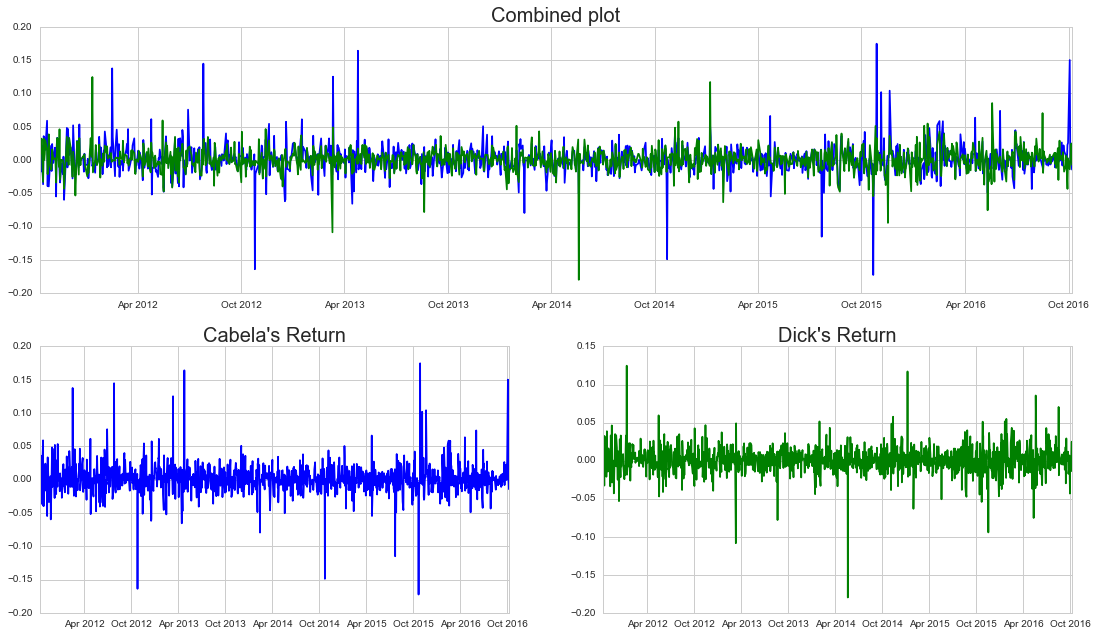

In [18]:
# Make plots to see returns
plot_return(cab_returns,"Cabela's Return",dks_returns,"Dick's Return",18.5,10.5,"blue","green")

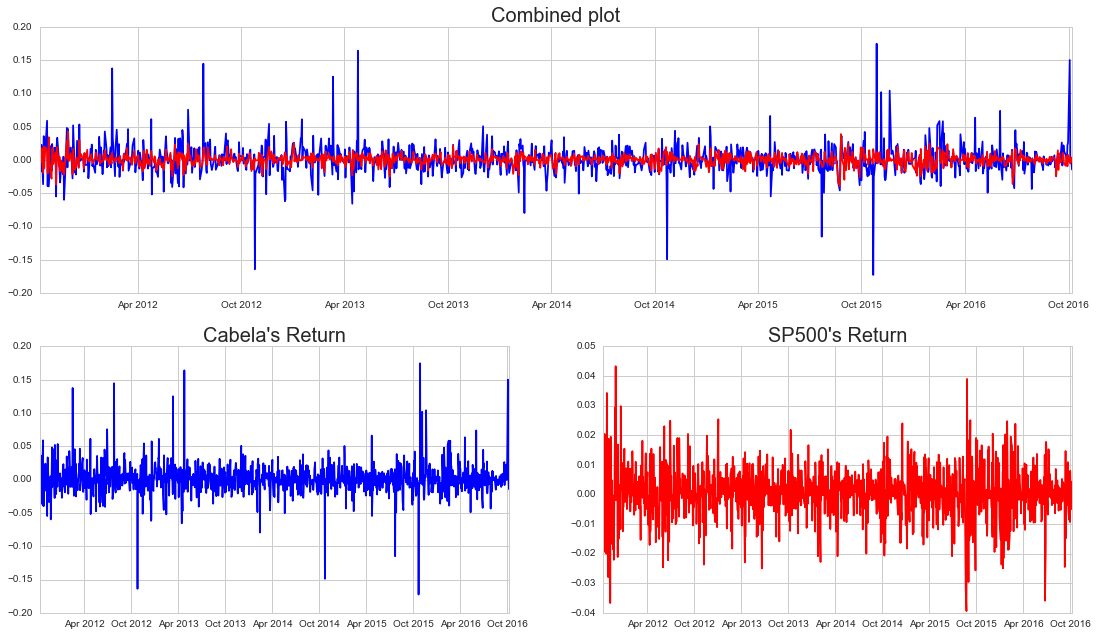

In [19]:
plot_return(cab_returns,"Cabela's Return",sp500_returns,"SP500's Return",18.5,10.5,"blue","red")

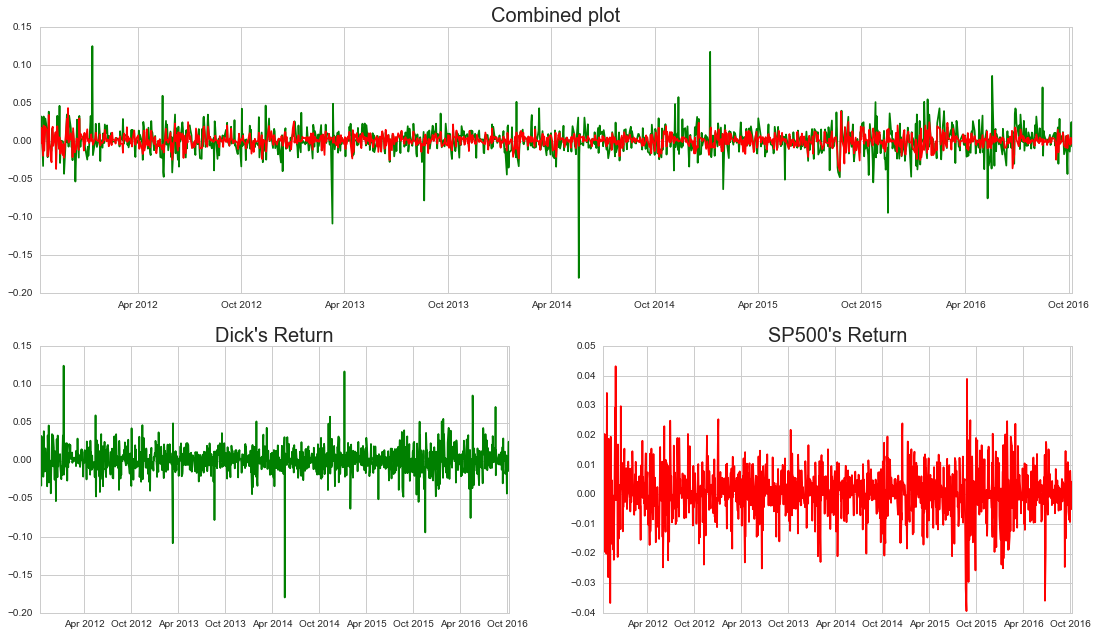

In [20]:
plot_return(dks_returns,"Dick's Return",sp500_returns,"SP500's Return",18.5,10.5,"green","red")

### Returns vs. Tweets 
The **black line** is the returns, and all the tweets related data has been scaled into [0,1] to see the trends

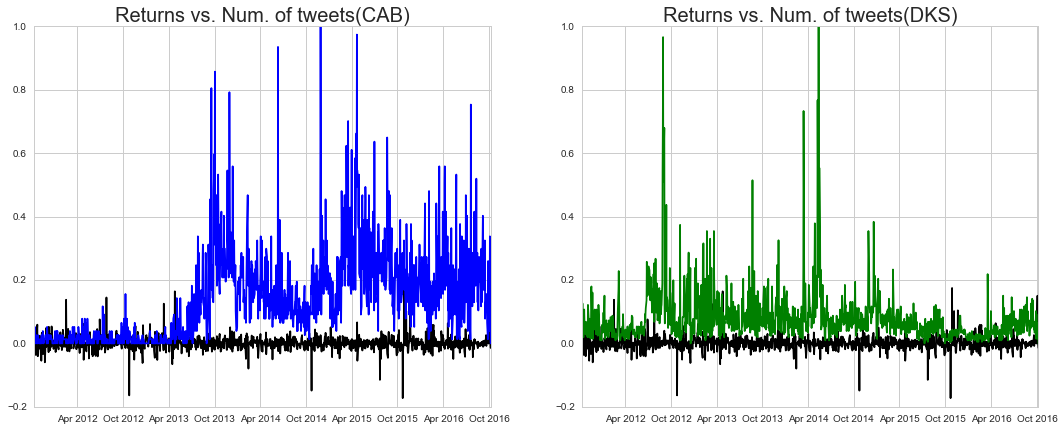

In [21]:
plot_tweets(cab_tnum,dks_tnum,cab,dks,"Num. of tweets")

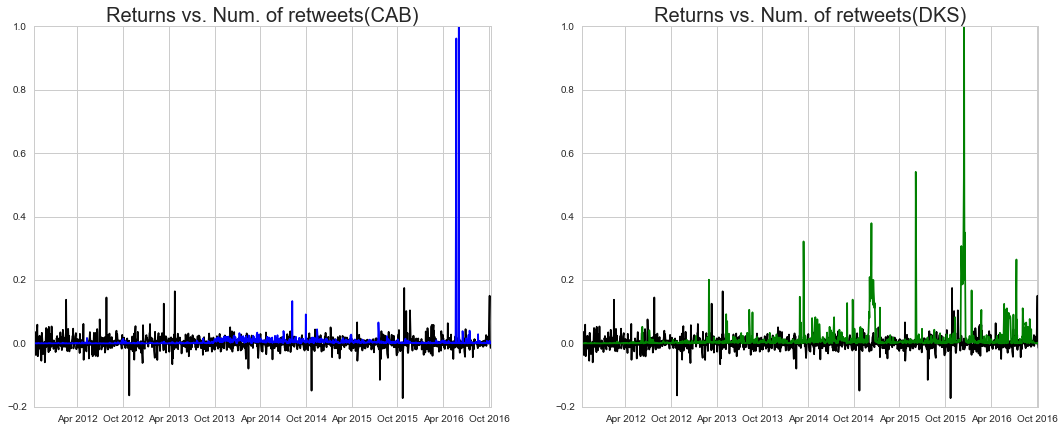

In [22]:
plot_tweets(cab_tret,dks_tret,cab,dks,"Num. of retweets")

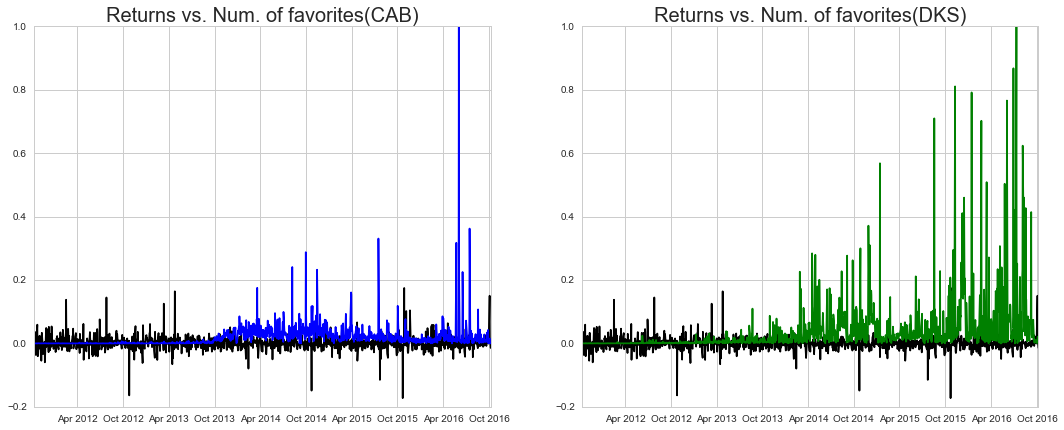

In [23]:
plot_tweets(cab_tfav,dks_tfav,cab,dks,"Num. of favorites")

## Feature Generation
#### 1.Leadlag correlation data (one vs. others) 
- cab_other, cab_other1(with tweets)
- dks_other, dks_other1(with tweets)
#### 2.Leadlag correlation data (one vs. others) with features 
- cab_feature
- dks_feature
#### 3.Window method data (one vs. itself)
- window=1:trainX,trainY,testX,testY
- window=10:trainX10,trainY10,testX10,testY10 
- window=10 + ICA=3:trainX10_ica3,trainY10,testX10_ica3,testY10

### 1.Leadlag correlation data

****************************************************************************************************
For CAB:
Calculate the leadlag correlations


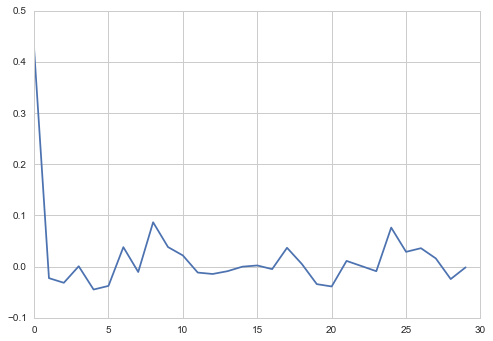

For dataset1 use lag = 
       corr1
0   0.426338
8   0.086763
24  0.076371


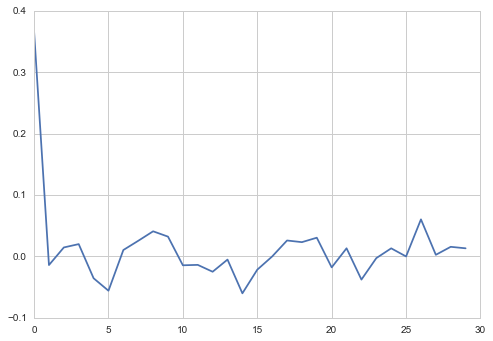

For dataset2 use lag = 
       corr2
0   0.366627
14 -0.060110
26  0.060374


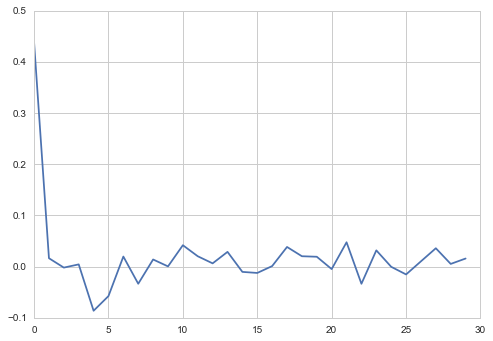

For dataset3 use lag = 
      corr3
0  0.438557
4 -0.086215


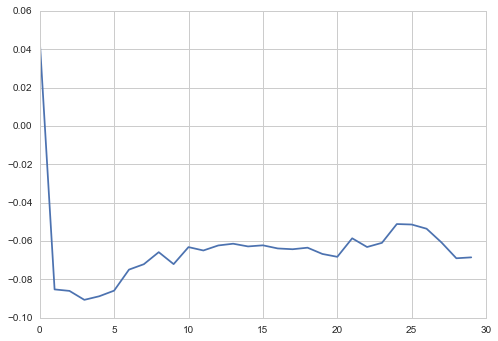

For dataset4 use lag = 
       corr4
1  -0.085198
2  -0.085974
3  -0.090637
4  -0.088776
5  -0.085847
6  -0.074881
7  -0.072058
8  -0.065780
9  -0.072013
10 -0.063145
11 -0.064902
12 -0.062286
13 -0.061377
14 -0.062793
15 -0.062214
16 -0.063844
17 -0.064252
18 -0.063446
19 -0.066722
20 -0.068209
22 -0.063097
23 -0.060923
27 -0.060702
28 -0.068965
29 -0.068491


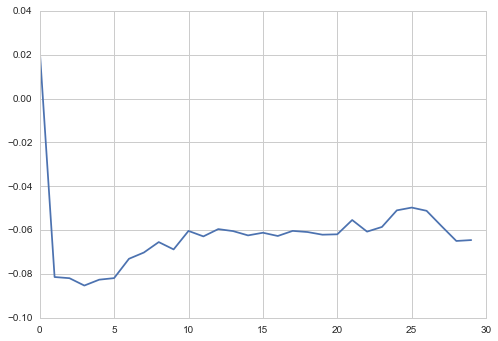

For dataset5 use lag = 
       corr5
1  -0.081401
2  -0.081928
3  -0.085286
4  -0.082607
5  -0.081901
6  -0.073076
7  -0.070226
8  -0.065460
9  -0.068803
10 -0.060368
11 -0.062864
13 -0.060454
14 -0.062410
15 -0.061199
16 -0.062677
17 -0.060357
18 -0.060875
19 -0.062087
20 -0.061913
22 -0.060694
28 -0.064951
29 -0.064543
****************************************************************************************************
(1233, 14)


In [24]:
# Leadlag correlation data
print "*"*100
print "For CAB:"

## Calculate the leadlag correlation with 4 years data
print "Calculate the leadlag correlations"
leadlag_corr(cab_4,[dks_4,hibb_4,sp500_4,cab_pe_4,cab_ps_4],0,30,0.06)
print "*"*100

## Put data together
cab_index = cab.index.values[24:]
#cab = cab.reset_index(drop=True)
frame=[cab,dks.shift(24),# dks.shift(8), dks.shift(10),dks.shift(24),
       hibb.shift(22), # hibb.shift(24),
       cab_pe.shift(3),cab_pe.shift(1),cab_pe.shift(2),cab_pe.shift(4),cab_pe.shift(5),cab_pe.shift(6),
       cab_ps.shift(1),cab_ps.shift(2),cab_ps.shift(3),cab_ps.shift(4),cab_ps.shift(5)]
cab_others = reduce(lambda left,right: pd.concat([left.reset_index(drop=True), right.reset_index(drop=True)],axis=1),frame)
cab_others = cab_others[24:]
cab_others = cab_others.set_index(cab_index)
cab_others.columns = ['returns', 'dks_24',"hibb_22","pe_1","pe_2","pe_3","pe_4","pe_5","pe_6",
                      "ps_1","ps_2","ps_3","ps_4","ps_5"]
print cab_others.shape

cab_others.to_csv("output/cabothers.csv", sep=';', encoding='utf-8')

****************************************************************************************************
For DKS:
Calculate the leadlag correlations


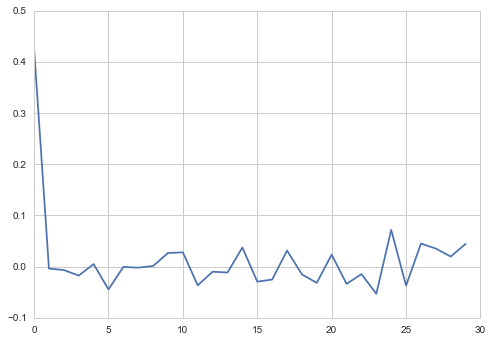

For dataset1 use lag = 
       corr1
0   0.426338
24  0.071839


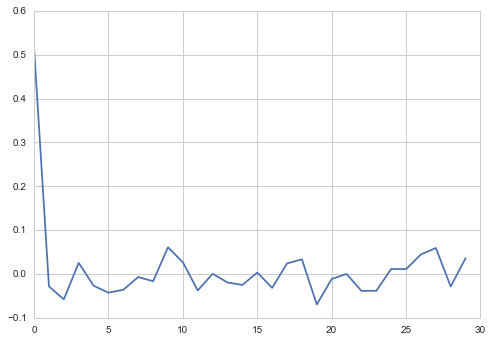

For dataset2 use lag = 
       corr2
0   0.515865
9   0.060867
19 -0.069590


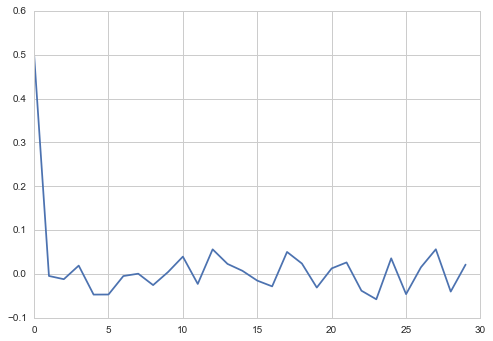

For dataset3 use lag = 
      corr3
0  0.501081


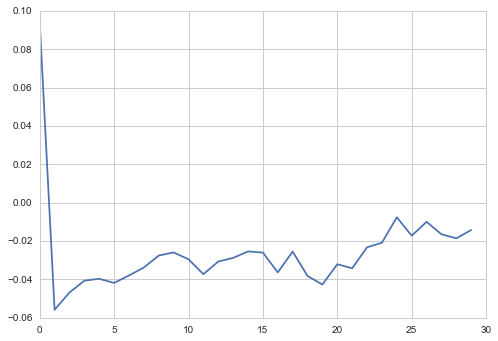

For dataset4 use lag = 
      corr4
0  0.094383


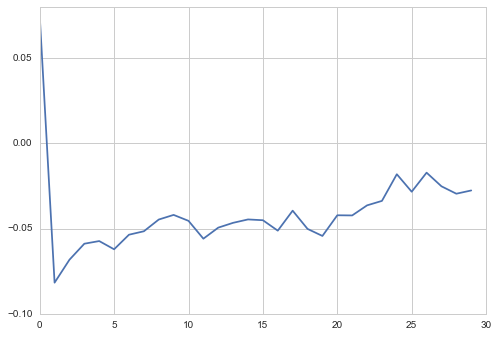

For dataset5 use lag = 
      corr5
0  0.075153
1 -0.081737
2 -0.068285
5 -0.062168
****************************************************************************************************


In [25]:
print "*"*100
print "For DKS:"
## Calculate the leadlag correlation with 4 years data
print "Calculate the leadlag correlations"
leadlag_corr(dks_4,[cab_4,hibb_4,sp500_4,dks_pe_4,dks_ps_4],0,30,0.06)
print "*"*100

## Put data together
dks_index = dks.index.values[29:]
frame=[dks,cab.shift(2), cab.shift(29),\
       hibb.shift(2), hibb.shift(29),\
       sp500.shift(2), sp500.shift(29),dks_ps.shift(3)]

dks_others = reduce(lambda left,right: pd.concat([left, right],axis=1),frame)
dks_others = dks_others[29:]
#dks_others = dks_others.set_index(dks_index)

dks_others.columns = ['returns', 'cab_2','cab_29','hibb_2',"hibb_29",\
                      "sp500_2","sp500_29",'dks_ps_3']
dks_others.to_csv("output/dksothers.csv", sep=';', encoding='utf-8')

In [26]:
# ## adding twitter data
# leadlag_corr(cab_4,[dks_4,hibb_4,sp500_4,cab_pe_4,cab_ps_4,cab_tnum_4,cab_tret_4,cab_tfav_4,cab_mood_4],0,30,0.07)
cab_index = dks.index.values[27:]
frame=[cab,dks.shift(24),# dks.shift(8), dks.shift(10),dks.shift(24),
       hibb.shift(22), # hibb.shift(24),
       cab_pe.shift(3),cab_pe.shift(1),cab_pe.shift(2),cab_pe.shift(4),cab_pe.shift(5),cab_pe.shift(6),
       cab_ps.shift(1),cab_ps.shift(2),cab_ps.shift(3),cab_ps.shift(4),cab_ps.shift(5),
       cab_tnum.shift(19),
       cab_tret.shift(2),cab_tret.shift(15),cab_tret.shift(23),
       cab_tfav.shift(2),cab_tfav.shift(13),cab_tfav.shift(15),cab_tfav.shift(23),
       cab_mood.shift(18),cab_mood.shift(19),cab_mood.shift(26),cab_mood.shift(27)]
cab_others1 = reduce(lambda left,right: pd.concat([left.reset_index(drop=True), right.reset_index(drop=True)],axis=1),frame)
cab_others1 = cab_others1[27:]
cab_others1 = cab_others1.set_index(cab_index)
cab_others1.columns = ['returns', 'dks_24',"hibb_22","pe_3","pe_1","pe_2","pe_4","pe_5","pe_6",\
                      "ps_1","ps_2","ps_3","ps_4","ps_5","num_19","ret_2","ret_15","ret_23","fav_2","fav_13","fav_15","fav_23",
                      "mood_18","mood_19","mood_26","mood_27"]
cab_others1.shape
cab_others1.to_csv("output/cabotherstweets.csv", sep=',', encoding='utf-8')

In [27]:
### Adding tweet data
# print "*"*100
# print "For DKS:"
# ## Calculate the leadlag correlation with 4 years data
# print "Calculate the leadlag correlations"
# leadlag_corr(dks_4,[cab_4,hibb_4,sp500_4,dks_pe_4,dks_ps_4,dks_tnum_4,dks_tret_4,dks_tfav_4],0,30,0.07)
# print "*"*100

# ## Put data together
dks_index = dks.index.values[29:]
frame=[dks,cab.shift(2), cab.shift(29),\
       hibb.shift(2), hibb.shift(29),\
       sp500.shift(2), sp500.shift(29),dks_ps.shift(3),\
       dks_tnum.shift(1),dks_tret.shift(1),dks_tfav.shift(1),dks_mood.shift(25)]

dks_others1 = reduce(lambda left,right: pd.concat([left, right],axis=1),frame)
dks_others1= dks_others1[29:]
#dks_others = dks_others.set_index(dks_index)

dks_others1.columns = ['returns', 'cab_2','cab_29','hibb_2',"hibb_29",\
                      "sp500_2","sp500_29","dks_ps_3","num_1","ret_1","fav_1","mood_25"]
dks_others1.to_csv("output/dksotherstweet.csv", sep=',', encoding='utf-8')

### 2. Leadlag correlation data with features 

In [28]:
### For CAB ###
dks_feature = leadlag_feature(dks,look_back=24)
pe_feature = leadlag_feature(cab_pe,look_back=6)[18:]
ps_feature = leadlag_feature(cab_ps,look_back=6)[18:]
tnum_feature = leadlag_feature(cab_tnum,look_back=19)[5:]
tret_feature = leadlag_feature(cab_tret,look_back=23)[1:]
tfav_feature = leadlag_feature(cab_tfav,look_back=23)[1:]
mood_feature = leadlag_feature(cab_mood,look_back=23)[1:]
frame=[cab[25:],dks_feature,pe_feature,ps_feature,tnum_feature,tret_feature,tfav_feature,mood_feature]
cab_feature = reduce(lambda left,right: pd.concat([left.reset_index(drop=True), 
                                                      right.reset_index(drop=True)],axis=1),frame)
cab_feature.columns = ['returns', 'dks_max',"dks_min","dks_mean","dks_med",
                       'pe_max',"pe_min","pe_mean","pe_med",
                      'ps_max',"ps_min","ps_mean","ps_med",
                      'tn_max',"tn_min","tn_mean","tn_med",
                      'tr_max',"tr_min","tr_mean","tr_med",
                      'tf_max',"tf_min","tf_mean","tf_med",
                      'md_max',"md_min","md_mean","md_med"]
cab_feature.to_csv("output/cab_feature.csv", sep=',', encoding='utf-8')

In [29]:
### For DKS ###
cab_feature = leadlag_feature(cab,look_back=24)
hibb_feature = leadlag_feature(hibb,look_back=19)[5:]
ps_feature = leadlag_feature(dks_ps,look_back=5)[21:]
tnum_feature = leadlag_feature(cab_tnum,look_back=16)[8:]
tfav_feature = leadlag_feature(cab_tfav,look_back=22)[2:]
frame=[dks[25:],cab_feature,hibb_feature,ps_feature,tnum_feature,tfav_feature]
dks_feature = reduce(lambda left,right: pd.concat([left.reset_index(drop=True), 
                                                      right.reset_index(drop=True)],axis=1),frame)
dks_feature.columns = ['returns', 'dks_max',"dks_min","dks_mean","dks_med",
                       'hibb_max',"hibb_min","hibb_mean","hibb_med",
                      'ps_max',"ps_min","ps_mean","ps_med",
                      'tn_max',"tn_min","tn_mean","tn_med",
                      'tf_max',"tf_min","tf_mean","tf_med"]
dks_feature.to_csv("output/dks_feature.csv", sep=',', encoding='utf-8')

### 3. Window method data

In [30]:
# with only t and (t-1) values
trainX,trainY,testX,testY = get_wmdata(seed=7,data=cab,split=0.7,look_back=1)
# with only t ...(t-10) values
trainX10,trainY10,testX10,testY10 = get_wmdata(seed=7,data=cab,split=0.7,look_back=10)

(879, 378)
(879, 378)


/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1)

In [31]:
### 3.ICA for window method data
# n_component=3 for window size 10
trainX10_ica3,trainY10,testX10_ica3,testY10 = wmd_ica(10, cab, split=0.7, look_back=10, n_component=3)

(879, 378)


/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/yujingma/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 

## Model Fittings

### Feature Extraction

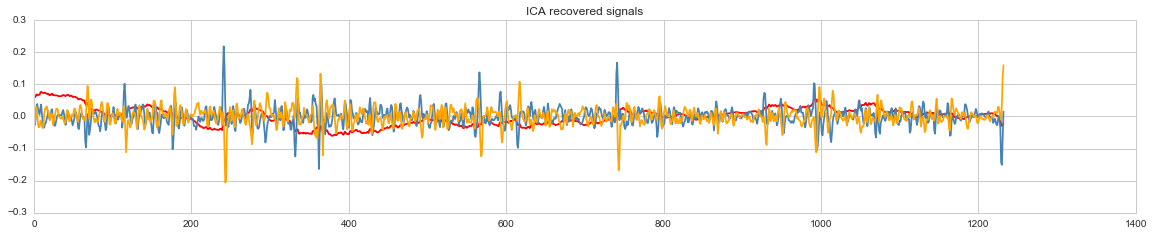

In [52]:
#get_ICA(cab_feature,n_comps=3,plot=True)
X = cab_others
n_comps=3
#X = (X-X.mean())#/X.std(ddof=0)
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
ICs = pd.DataFrame({"c1":S_[:,0],'c2':S_[:,1],'c3':S_[:,2]})
    # Make plots to see the signal

fig=plt.figure()
fig.set_size_inches(18,16)
models = [S_]
names = ['ICA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.subplots_adjust(0.09, 0.04, 0.94, 0.94, 0.26, 0.46)
plt.show()


### 1.  Linear regression (Leadlag correlation data )

(863, 370)
Fitting a linear regression model with all the shifts
Intercept: -0.000000
Coefficients: [ 0.09355299 -0.05850729 -0.00086127  0.00133558 -0.00101822 -0.00120562
 -0.00088618  0.00201807]
R^2 for training set: 0.0219864890835
RMSE: 0.02140
R^2 for test set: -0.209518825255
RMSE: 0.02478
****************************************************************************************************


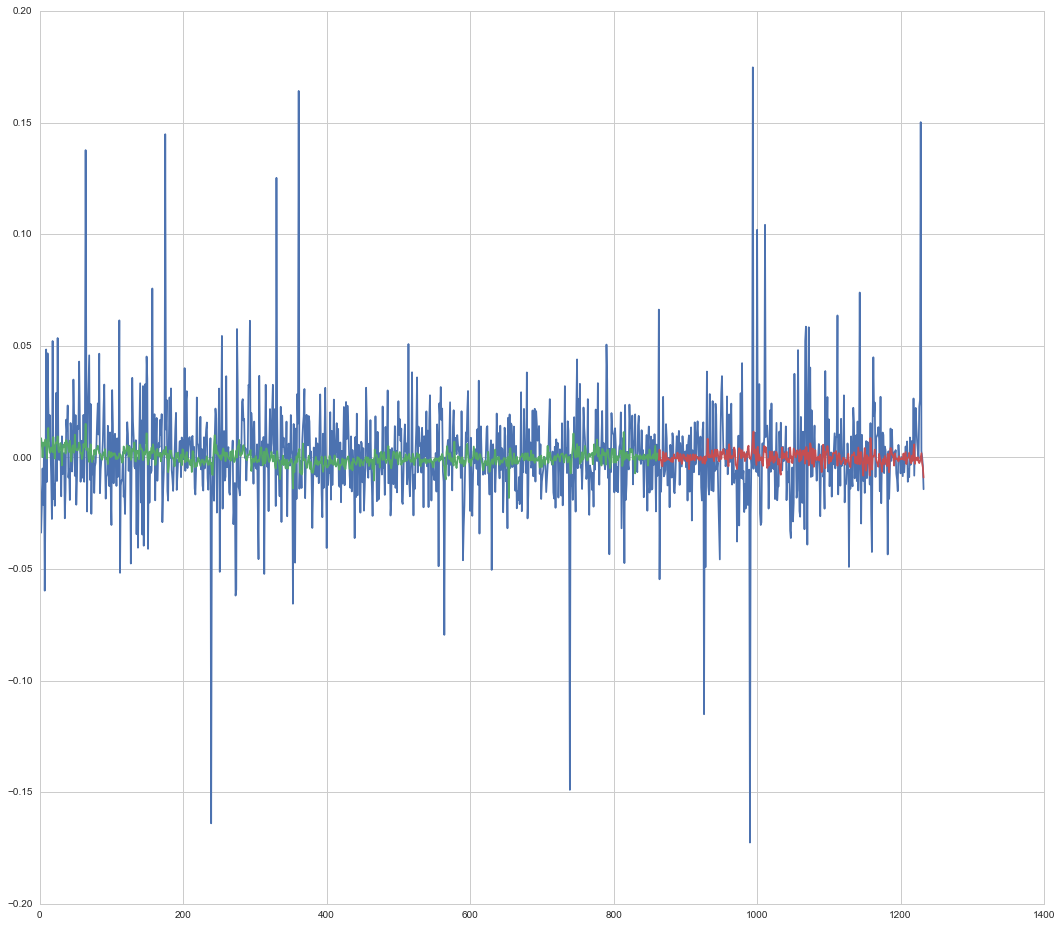

In [260]:
##### For CAB #####
## Separate and Standaridize

# split into train and test sets

train,test = split_trn_tst(cab_others,porp=0.7)

X_trn = train[['dks_24',"hibb_22","pe_1","pe_2","pe_3","pe_4","pe_5","pe_6"]]
                      #"ps_1","ps_2","ps_3","ps_4","ps_5"]] # input varialbe
Y_trn = train['returns'] # output varialbe
X_tst = test[['dks_24',"hibb_22","pe_1","pe_2","pe_3","pe_4","pe_5","pe_6"]]
                      #"ps_1","ps_2","ps_3","ps_4","ps_5"]] # input varialbe
Y_tst = test['returns']


# standardize the data
X_trn = (X_trn-X_trn.mean())#/X_trn.std(ddof=0)
X_tst = (X_tst-X_trn.mean())#/X_trn.std(ddof=0)
Y_trn = (Y_trn-Y_trn.mean())#/Y_trn.std(ddof=0)
Y_tst = (Y_tst-Y_trn.mean())#/Y_trn.std(ddof=0)

## Fitting a linear regression model
print "Fitting a linear regression model with all the shifts"
ols = lm.LinearRegression()
ols.fit(X_trn, Y_trn)
print "Intercept: %f" %ols.intercept_
print "Coefficients: %s" %str(ols.coef_)


#model = sm.OLS(Y_trn, X_trn)
#results = model.fit()
#print results.summary()
# save the prediction
lm_cabs = ols.predict(X_tst)-ols.predict(X_tst).mean() # adjusted the shift of the prediction
lm_cabn = ols.predict(X_trn)

# training and test errors
print "R^2 for training set:",
print ols.score(X_trn, Y_trn)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(Y_trn, lm_cabn))

print "R^2 for test set:",
print ols.score(X_tst, Y_tst)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(Y_tst, lm_cabs))

print "*"*100
# Make plots
plot_lm(cab_others["returns"],lm_cabn,lm_cabs)

(859, 369)
Fitting a linear regression model with all the shifts
Intercept: 0.000000
Coefficients: [ 0.00371677  0.04965778 -0.10294097  0.02550683  0.08703417  0.02043865
 -0.01200454]
R^2 for training set: 0.0180601412105
RMSE: 0.01712
----------------------------------------------------------------------------------------------------
R^2 for test set: -0.262948309705
RMSE: 0.01975
****************************************************************************************************


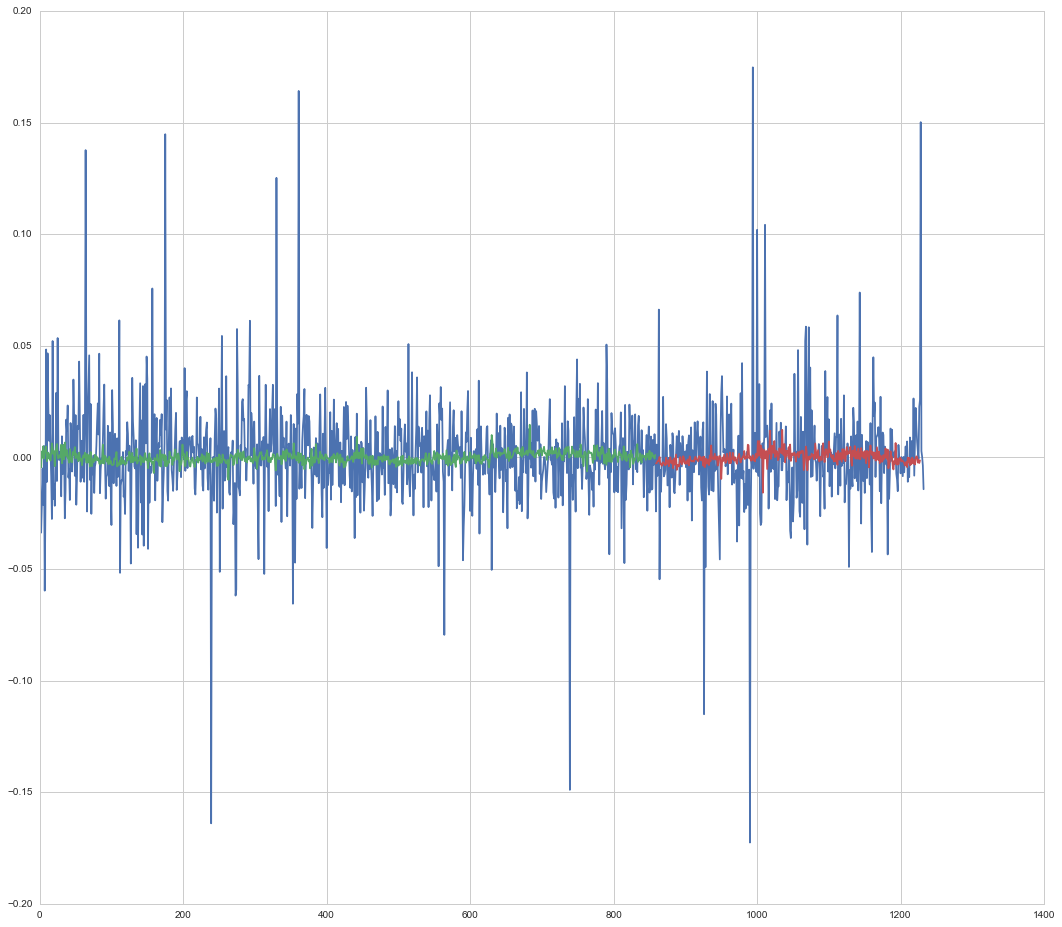

In [261]:
##### For DKS #####
## Separate and Standaridize

# split into train and test sets
train,test = split_trn_tst(dks_others,porp=0.7)

X_trn1 = train[ ['cab_2','cab_29','hibb_2',"hibb_29",\
                      "sp500_2","sp500_29",'dks_ps_3']] # input varialbe
Y_trn1 = train['returns'] # output varialbe
X_tst1 = test[ ['cab_2','cab_29','hibb_2',"hibb_29",\
                      "sp500_2","sp500_29",'dks_ps_3']] # input varialbe
Y_tst1 = test['returns']

# standardize the data
X_trn1 = (X_trn1-X_trn1.mean())#/X_trn.std(ddof=0)
X_tst1 = (X_tst1-X_trn1.mean())#/X_trn.std(ddof=0)
Y_trn1 = (Y_trn1-Y_trn1.mean())#/Y_trn.std(ddof=0)
Y_tst1 = (Y_tst1-Y_trn1.mean())#/Y_trn.std(ddof=0)

## Fitting a linear regression model
print "Fitting a linear regression model with all the shifts"
ols = lm.LinearRegression()
ols.fit(X_trn1, Y_trn1)
print "Intercept: %f" %ols.intercept_
print "Coefficients: %s" %str(ols.coef_)


#model2 = sm.OLS(Y_trn, X_trn)
#results = model2.fit()
#print results.summary()

# save the prediction
lm_dkst = ols.predict(X_tst1)-ols.predict(X_tst1).mean() # adjusted the shift of the prediction
lm_dksn = ols.predict(X_trn1)
# training and test errors
print "R^2 for training set:",
print ols.score(X_trn1, Y_trn1)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(Y_trn1, lm_dksn))
print '-'*100

print "R^2 for test set:",
print ols.score(X_tst1, Y_tst1)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(Y_tst1, lm_dkst))

print "*"*100
                               
# Make plots
plot_lm(dks_others["returns"],lm_dksn,lm_dkst)


Note: cab_others and cab_others1 are both tried, cab_others shows better performance 

### 2. Ridge regression with Cross Validation

 C = 0
Train Score: 0.02298 RMSE
Test Score: 0.02184 RMSE
 C = 10000
Train Score: 0.02333 RMSE
Test Score: 0.02160 RMSE
 C = 20000
Train Score: 0.02333 RMSE
Test Score: 0.02160 RMSE
********************************************************************************
10000


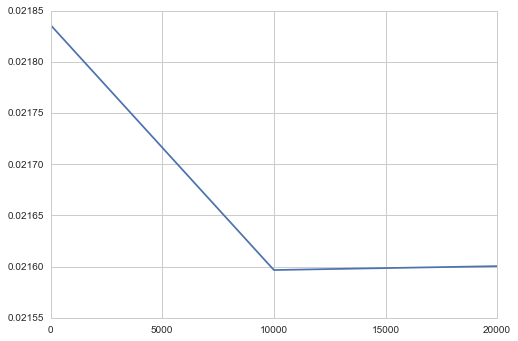

In [206]:
##### For CAB #####
C_list = np.arange(0,30000, 10000)
index = C_list
rmse = pd.DataFrame(columns=['train_rmse','test_rmse'],\
                    index = index)
rmse = rmse.fillna(0)
for c in C_list:
    print " C = "+ str(c)
    r_trn,r_tst = cv_ridge(cab_others,k_fold=5,alpha=c)
    rmse.loc[c] = [r_trn,r_tst]
c_= rmse["test_rmse"].idxmin()
print "*"* 80
print c_
plt.plot(rmse["test_rmse"])


In [207]:
print "Fitting a linear regression model with all the shifts"
rg = lm.Ridge(alpha = c_)
rg.fit(X_trn, Y_trn)
print "Intercept: %f" %rg.intercept_
print "Coefficients: %s" %str(rg.coef_)
# save the prediction
rg_cabt = rg.predict(X_tst)-rg.predict(X_tst).mean() # adjusted the shift of the prediction
rg_cabn = rg.predict(X_trn)
# training and test errors
print "R^2 for training set:",
print rg.score(X_trn, Y_trn)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(Y_trn, rg_cabn))

print "R^2 for test set:",
print rg.score(X_tst, Y_tst)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(Y_tst, rg_cabt))
print "with alpah = "+ str(c_)
print "*"*100
# Make plots
#plot_lm(cab_others["returns"],rg_cabn,rg_cabt)

Fitting a linear regression model with all the shifts
Intercept: -0.000000
Coefficients: [  2.68964194e-06  -1.69906950e-06  -1.17835682e-04  -7.66946245e-05
  -1.06423965e-04  -1.12568130e-04  -8.49485821e-05  -4.18315138e-05]
R^2 for training set: 0.00881960765486
RMSE: 0.02155
R^2 for test set: -0.166816655887
RMSE: 0.02483
with alpah = 10000
****************************************************************************************************


In [208]:
df =pd.DataFrame(np.concatenate([rg_cabn,rg_cabt]))
df.columns =["rg_cab"]
df.to_csv("output/rg_cab.csv", sep=',')

 C = 0.0
Train Score: 0.01699 RMSE
Test Score: 0.01806 RMSE
 C = 2.0612244898
Train Score: 0.01721 RMSE
Test Score: 0.01778 RMSE
 C = 4.12244897959
Train Score: 0.01723 RMSE
Test Score: 0.01776 RMSE
 C = 6.18367346939
Train Score: 0.01724 RMSE
Test Score: 0.01775 RMSE
 C = 8.24489795918
Train Score: 0.01725 RMSE
Test Score: 0.01775 RMSE
 C = 10.306122449
Train Score: 0.01725 RMSE
Test Score: 0.01775 RMSE
 C = 12.3673469388
Train Score: 0.01726 RMSE
Test Score: 0.01775 RMSE
 C = 14.4285714286
Train Score: 0.01726 RMSE
Test Score: 0.01774 RMSE
 C = 16.4897959184
Train Score: 0.01726 RMSE
Test Score: 0.01774 RMSE
 C = 18.5510204082
Train Score: 0.01726 RMSE
Test Score: 0.01774 RMSE
 C = 20.612244898
Train Score: 0.01727 RMSE
Test Score: 0.01774 RMSE
 C = 22.6734693878
Train Score: 0.01727 RMSE
Test Score: 0.01774 RMSE
 C = 24.7346938776
Train Score: 0.01727 RMSE
Test Score: 0.01774 RMSE
 C = 26.7959183673
Train Score: 0.01727 RMSE
Test Score: 0.01774 RMSE
 C = 28.8571428571
Train Score: 0

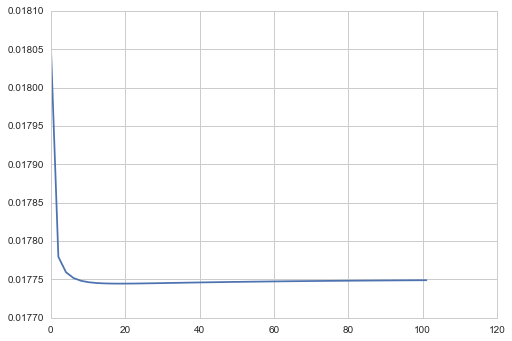

In [209]:
##### For DKS #####
C_list = np.linspace(0, 101, num =50)
index = C_list
rmse = pd.DataFrame(columns=['train_rmse','test_rmse'],\
                    index = index)
rmse = rmse.fillna(0)
for c in C_list:
    print " C = "+ str(c)
    r_trn,r_tst = cv_ridge(dks_others,k_fold=5,alpha=c)
    rmse.loc[c] = [r_trn,r_tst]
c_= rmse["test_rmse"].idxmin()
print "*"* 80
print c_
plt.plot(rmse["test_rmse"])


In [210]:
print "Fitting a linear regression model with all the shifts"
rg = lm.Ridge(alpha = c_)
rg.fit(X_trn1, Y_trn1)
print "Intercept: %f" %rg.intercept_
print "Coefficients: %s" %str(rg.coef_)
# save the prediction
rg_dkst = rg.predict(X_tst1)-rg.predict(X_tst1).mean() # adjusted the shift of the prediction
rg_dksn = rg.predict(X_trn1)
# training and test errors
print "R^2 for training set:",
print rg.score(X_trn1, Y_trn1)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(Y_trn1, rg_dksn))

print "R^2 for test set:",
print rg.score(X_tst1, Y_tst1)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(Y_tst1, rg_dkst))

print "*"*100
# Make plots
#plot_lm(cab_others["returns"],rg_cabn,rg_cabt)


Fitting a linear regression model with all the shifts
Intercept: 0.000000
Coefficients: [ -1.59648089e-04   1.20788472e-03  -9.34056188e-04   6.56405135e-04
   1.43229221e-06   3.17741351e-04  -3.82674606e-03]
R^2 for training set: 0.00305882411741
RMSE: 0.01725
R^2 for test set: -0.0243558706403
RMSE: 0.01944
****************************************************************************************************


In [510]:
df =pd.DataFrame(np.concatenate([rg_dksn,rg_dkst]))
df.columns =["rg_dks"]
df.to_csv("output/rg_dks.csv", sep=',')

In [273]:
cab_feature

,returns,dks_max,dks_min,dks_mean,dks_med,pe_max,pe_min,pe_mean,pe_med,ps_max,...,tr_mean,tr_med,tf_max,tf_min,tf_mean,tf_med,md_max,md_min,md_mean,md_med
0,-0.016949,0.038632,-0.033736,0.004966,5.686946e-03,13.121,12.404,12.842667,12.8715,0.6542,...,3.347826,0.0,4.0,0.0,0.521739,0.0,0.173000,-0.061800,0.039278,0.000000
1,-0.033699,0.038632,-0.033736,0.005146,5.686946e-03,13.121,12.404,12.902333,13.0480,0.6542,...,3.521739,0.0,4.0,0.0,0.565217,0.0,0.173000,-0.061800,0.044341,0.000000
2,-0.021492,0.046235,-0.033736,0.006433,5.686946e-03,13.121,12.404,12.885500,12.9975,0.6542,...,3.782609,0.0,4.0,0.0,0.565217,0.0,0.172000,-0.061800,0.038398,0.000000
3,-0.004973,0.046235,-0.033736,0.004815,2.146015e-03,13.111,12.404,12.774500,12.7855,0.6537,...,3.304348,0.0,4.0,0.0,0.478261,0.0,0.172000,-0.061800,0.040482,0.000000
4,-0.021241,0.046235,-0.033736,0.003029,8.927312e-04,13.111,12.187,12.738333,12.7855,0.6537,...,3.347826,0.0,4.0,0.0,0.478261,0.0,0.172000,-0.061800,0.047135,0.014500
5,0.005106,0.046235,-0.033736,0.004416,1.009494e-03,13.111,12.126,12.645667,12.6720,0.6537,...,3.347826,0.0,4.0,0.0,0.478261,0.0,0.172000,-0.061800,0.047135,0.014500
6,-0.059695,0.046235,-0.033736,0.003052,3.858948e-04,13.111,11.869,12.439500,12.3210,0.6537,...,3.521739,0.0,4.0,0.0,0.565217,0.0,0.172000,-0.061800,0.047160,0.014500
7,-0.022062,0.046235,-0.033736,0.002758,2.513289e-04,12.889,11.869,12.242500,12.1565,0.6427,...,3.173913,0.0,4.0,0.0,0.608696,0.0,0.172000,0.000000,0.050181,0.014500
8,0.048343,0.046235,-0.043016,0.000596,-2.512027e-04,12.455,11.217,11.963833,12.0275,0.6210,...,3.217391,1.0,4.0,0.0,0.652174,0.0,0.172000,0.000000,0.051911,0.021695
9,-0.010979,0.046235,-0.043016,-0.001211,-5.028478e-04,12.187,10.970,11.716333,11.8990,0.6077,...,3.521739,1.0,4.0,0.0,0.782609,0.0,0.172000,0.000000,0.048126,0.021695


In [314]:
# ##### For CAB #####
dataset = cab_feature
split = 0.7
shape = dataset.shape
dataset = dataset.values

scaler = MinMaxScaler(feature_range=(0, 1)) # or 0,1
dataset = scaler.fit_transform(dataset).reshape(shape)
# split into train and test sets
train_size = int(len(dataset) * split)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

trainX = train[:,1:]
trainY = train[:,0]
testX = test[:,1:]
testY = test[:,0]

C_list = np.arange(0,100000, 10000)
index = C_list
rmse = pd.DataFrame(columns=['train_rmse','test_rmse'],\
                    index = index)
rmse = rmse.fillna(0)
for c in C_list:
    print " C = "+ str(c)
    r_trn,r_tst = cv_ridge(train,k_fold=5,alpha=c)
    rmse.loc[c] = [r_trn,r_tst]
c_= rmse["test_rmse"].idxmin()
print "*"* 80
print c_
plt.plot(rmse["test_rmse"])

print "Fitting a linear regression model with all the shifts"
rg = lm.Ridge(alpha = c_)
rg.fit(trainX, trainY)
print "Intercept: %f" %rg.intercept_
print "Coefficients: %s" %str(rg.coef_)
# save the prediction
testPredict = rg.predict(testX) 
trainPredict = rg.predict(trainX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# training and test errors
print "R^2 for training set:",
print rg.score(trainX, trainY)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(trainY, trainPredict))

print "R^2 for test set:",
print rg.score(testX, testY)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(testY, testPredict))
print "with alpah = "+ str(c_)
print "*"*100

In [315]:
##### For DKS #####
dataset = dks_feature
split = 0.7
shape = dataset.shape
dataset = dataset.values

scaler = MinMaxScaler(feature_range=(0, 1)) # or 0,1
dataset = scaler.fit_transform(dataset).reshape(shape)
# split into train and test sets
train_size = int(len(dataset) * split)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

trainX = train[:,1:]
trainY = train[:,0]
testX = test[:,1:]
testY = test[:,0]

C_list = np.arange(0,100000, 10000)
index = C_list
rmse = pd.DataFrame(columns=['train_rmse','test_rmse'],\
                    index = index)
rmse = rmse.fillna(0)
for c in C_list:
    print " C = "+ str(c)
    r_trn,r_tst = cv_ridge(train,k_fold=5,alpha=c)
    rmse.loc[c] = [r_trn,r_tst]
c_= rmse["test_rmse"].idxmin()
print "*"* 80
print c_
plt.plot(rmse["test_rmse"])

print "Fitting a linear regression model with all the shifts"
rg = lm.Ridge(alpha = c_)
rg.fit(trainX, trainY)
print "Intercept: %f" %rg.intercept_
print "Coefficients: %s" %str(rg.coef_)
# save the prediction
testPredict = rg.predict(testX) 
trainPredict = rg.predict(trainX)

# training and test errors
print "R^2 for training set:",
print rg.score(trainX, trainY)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(trainY, trainPredict))

print "R^2 for test set:",
print rg.score(testX, testY)
print "RMSE: %.5f" % math.sqrt(mean_squared_error(testY, testPredict))
print "with alpah = "+ str(c_)
print "*"*100

### 3. AR model

/Users/yujingma/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/Users/yujingma/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()


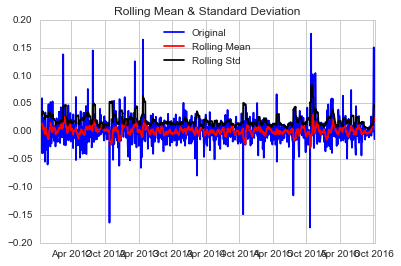

Results of Dickey-Fuller Test:
Test Statistic                -1.856349e+01
p-value                        2.086195e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.253000e+03
Critical Value (5%)           -2.863849e+00
Critical Value (1%)           -3.435580e+00
Critical Value (10%)          -2.568000e+00
dtype: float64


In [423]:
##### For CAB #####
test_stationarity(cab)

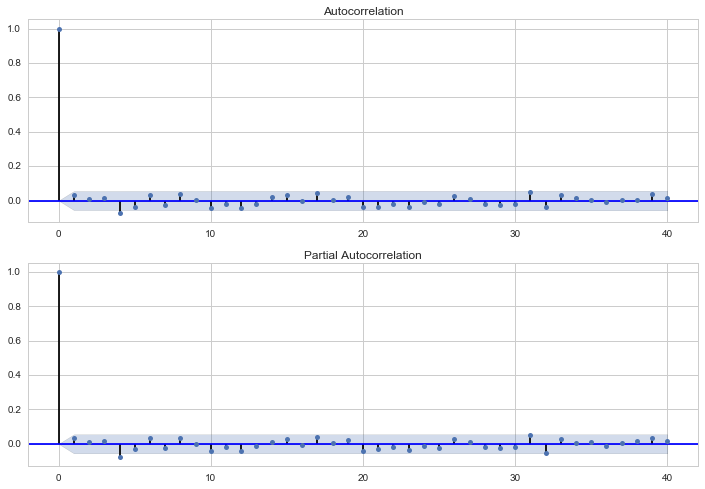

In [430]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(cab.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(cab, lags=40, ax=ax2)


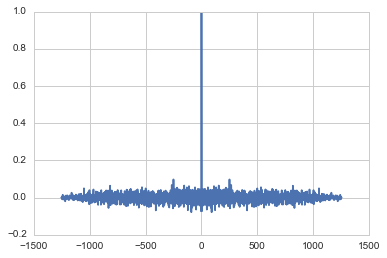

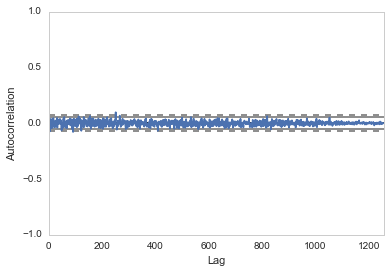

In [431]:
cab1 = cab
cab1 = (cab1 - cab1.mean()) / (cab1.std())
plt.acorr(cab1,maxlags = len(cab1) -1, linestyle = "solid", usevlines = False, marker='')
plt.show()
autocorrelation_plot(cab1)
plt.show()

const              0.001038
ar.L1.Adj Close    0.032064
ar.L2.Adj Close    0.007998
ar.L3.Adj Close    0.018676
ar.L4.Adj Close   -0.074131
dtype: float64
-5936.45429633 -5905.63539708 -5924.87165505
**************************************************
check residual
**************************************************
Prediction for the 5th year
RMSE: 0.02466


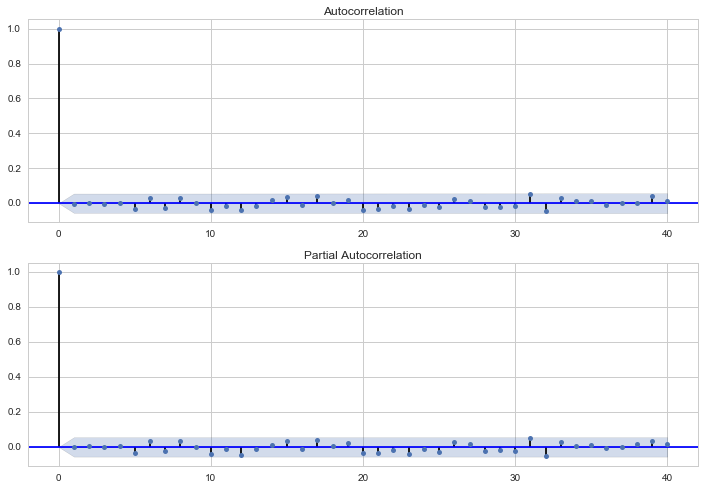

In [493]:
## according the plots, try ar(4,0)
arma_mod40 = sm.tsa.ARMA(cab, (4,0)).fit()
print arma_mod40.params
print arma_mod40.aic, arma_mod40.bic, arma_mod40.hqic
## check residual
print "*"*50
resid40 = arma_mod40.resid
print  "check residual"
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid40.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid40, lags=40, ax=ax2)
print "*"*50
print  "Prediction for the 5th year"
length = cab.shape[0]
predict_cab40 = arma_mod40.predict(7*length/10,length-1, dynamic=True)
cab_test = cab[(7*length/10):]
#print predict_cab40
#print cab_test
print "RMSE: %.5f" % math.sqrt(mean_squared_error(cab_test, predict_cab40))


/Users/yujingma/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/Users/yujingma/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).std()


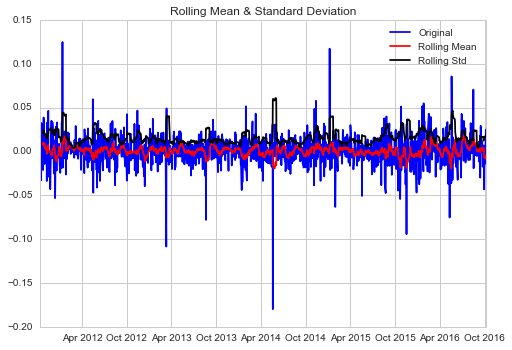

Results of Dickey-Fuller Test:
Test Statistic                  -37.591524
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1256.000000
Critical Value (5%)              -2.863844
Critical Value (1%)              -3.435567
Critical Value (10%)             -2.567997
dtype: float64


In [316]:
##### For DKS #####
test_stationarity(dks)

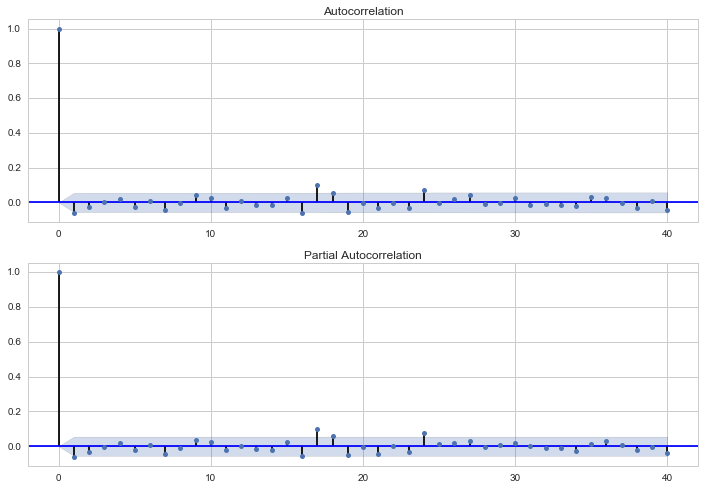

In [317]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dks.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dks, lags=40, ax=ax2)

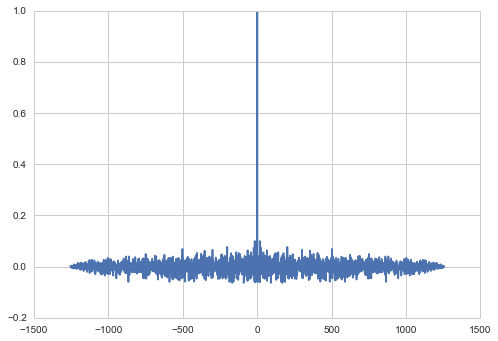

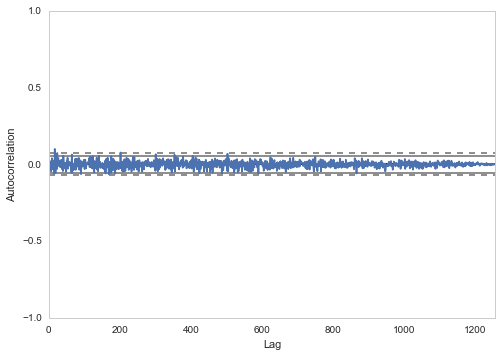

In [319]:
dks1 = dks
dks1 = (dks1 - dks1.mean()) / (dks1.std())
plt.acorr(dks1,maxlags = len(dks1) -1, linestyle = "solid", usevlines = False, marker='')
plt.show()
autocorrelation_plot(dks1)
plt.show()

/Users/yujingma/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


const       0.000696
ar.L1.y    -0.053160
ar.L2.y    -0.031886
ar.L3.y     0.000039
ar.L4.y     0.022337
ar.L5.y    -0.027724
ar.L6.y     0.006904
ar.L7.y    -0.046411
ar.L8.y    -0.007571
ar.L9.y     0.036364
ar.L10.y    0.031015
ar.L11.y   -0.027093
ar.L12.y    0.005629
ar.L13.y   -0.018688
ar.L14.y   -0.019820
ar.L15.y    0.024211
ar.L16.y   -0.053132
ar.L17.y    0.101446
dtype: float64
-6520.68894946 -6423.0957685 -6484.01058539
**************************************************
check residual
**************************************************
Prediction for the 5th year


/Users/yujingma/anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


RMSE: 0.01936


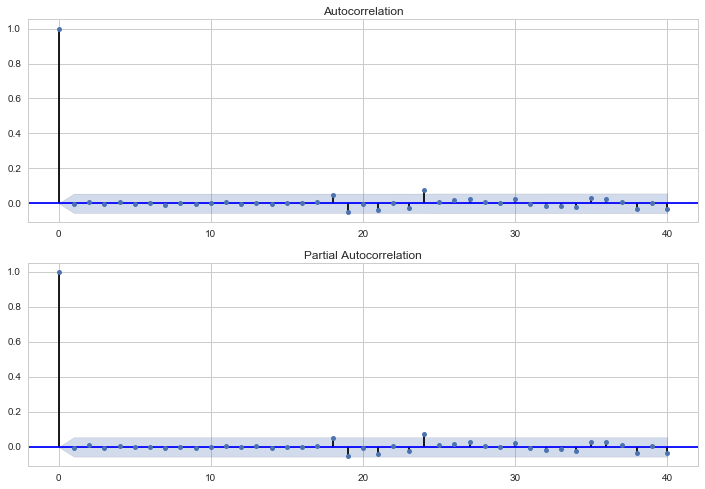

In [320]:
## according the plots, try ar(17,0)
arma_mod70 = sm.tsa.ARMA(dks, (17,0)).fit()
print arma_mod70.params
print arma_mod70.aic, arma_mod70.bic, arma_mod70.hqic
## check residual
print "*"*50
resid70 = arma_mod70.resid
print  "check residual"
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid70.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid70, lags=40, ax=ax2)
print "*"*50
print  "Prediction for the 5th year"
length = dks.shape[0]
predict_dks71 = arma_mod70.predict(7*length/10,length-1, dynamic=True)
dks_test = dks[(7*length/10):]

print "RMSE: %.5f" % math.sqrt(mean_squared_error(dks_test, predict_dks71))

### 4. LSTM
### Model1: window method with one layer

/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/1
874/874 [==============================] - 21s - loss: 0.0069    
Epoch 1/1
874/874 [==============================] - 21s - loss: 0.0042    
Epoch 1/1
874/874 [==============================] - 20s - loss: 0.0042    
Epoch 1/1
874/874 [==============================] - 20s - loss: 0.0042    
Epoch 1/1
874/874 [==============================] - 19s - loss: 0.0042    
Epoch 1/1
874/874 [==============================] - 20s - loss: 0.0042    
Epoch 1/1
874/874 [==============================] - 20s - loss: 0.0042    
Epoch 1/1
874/874 [==============================] - 22s - loss: 0.0042    
Epoch 1/1
874/874 [==============================] - 20s - loss: 0.0042    
Epoch 1/1
874/874 [==============================] - 21s - loss: 0.0042    
Epoch 1/1
874/874 [==============================] - 22s - loss: 0.0042    
Epoch 1/1
874/874 [==============================] - 21s - loss: 0.0041    
Epoch 1/1
874/874 [==============================] - 21s - loss: 0.0041    
Epoch 1/1
87

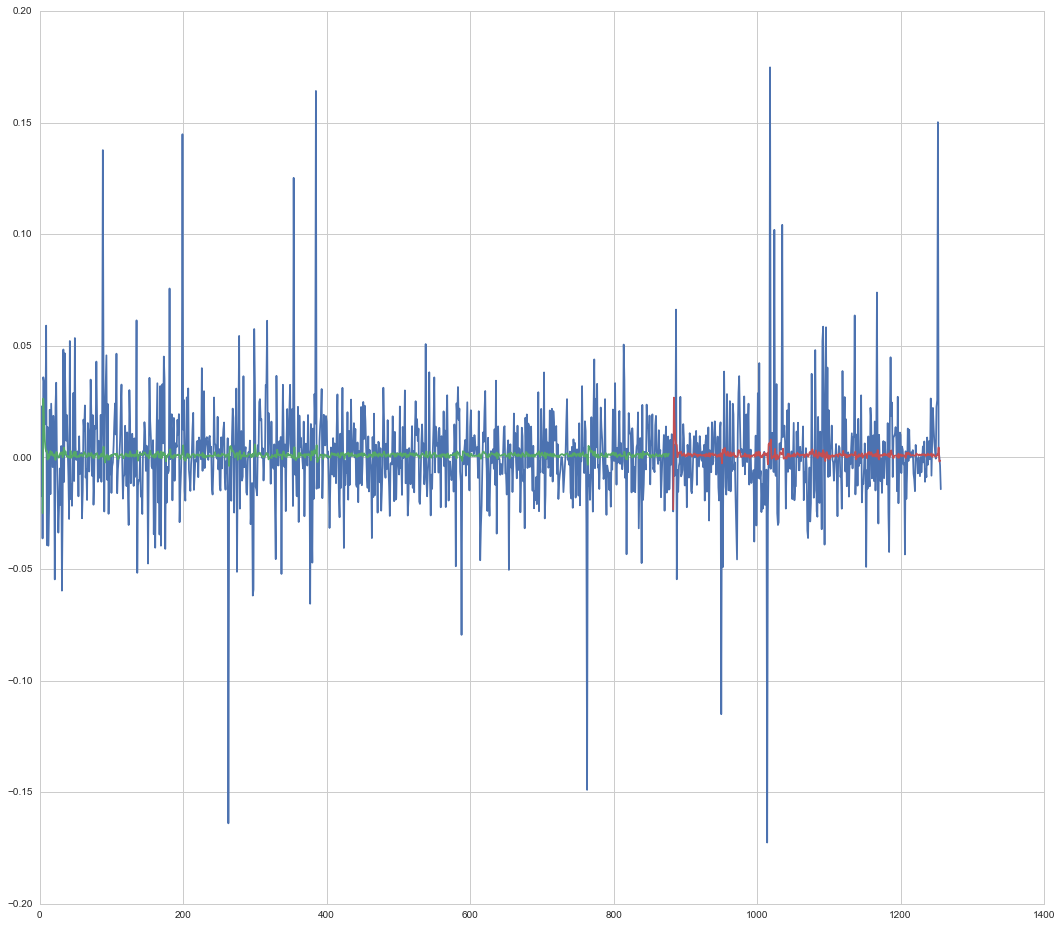

In [132]:
### Model1 with window size but no ICA 
## According to AR, Window size= 4 
lstm_np1,lstm_tp1=LSM(cab,seed=10,look_back=4,split=0.7,n_loop=50,layer2=4,show_log = 1,batch_size = 1,cv=False)
#Train Score: 0.02176 RMSE
#Test Score: 0.02454 RMSE
# save data
#df = pd.DataFrame([np.concatenate([lstm_np1,lstm_tp1])].reshape())
df =pd.DataFrame(np.concatenate([lstm_np1,lstm_tp1]))
df.columns =["lstm_cab1"]
df.to_csv("output/lstm_cab1.csv", sep=',')
# Train Score: 0.02184 RMSE
#Test Score: 0.02477 RMSE

/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/1
868/868 [==============================] - 38s - loss: 0.0064    
Epoch 1/1
868/868 [==============================] - 39s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 39s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 39s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 39s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 39s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 36s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 36s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 39s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 39s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 38s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 37s - loss: 0.0041    
Epoch 1/1
868/868 [==============================] - 36s - loss: 0.0041    
Epoch 1/1
86

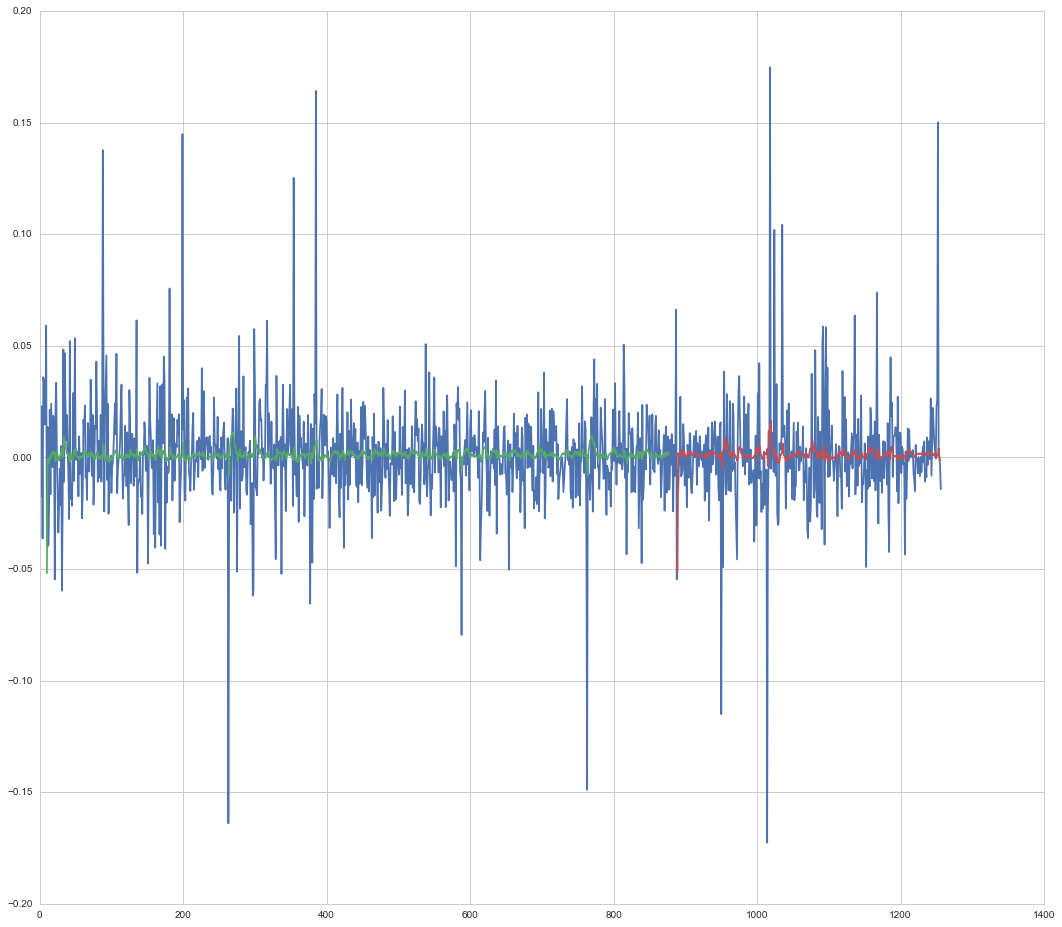

In [25]:
lstm_np1,lstm_tp1=LSM(cab,seed=10,look_back=10,split=0.7,n_loop=100,layer2=4,show_log = 1,batch_size = 1,cv=False)
#Train Score: 0.02176 RMSE
#Test Score: 0.02454 RMSE
# save data
#df = pd.DataFrame([np.concatenate([lstm_np1,lstm_tp1])].reshape())
df =pd.DataFrame(np.concatenate([lstm_np1,lstm_tp1]))
df.columns =["lstm_cab1.1"]
df.to_csv("output/lstm_cab1_1.csv", sep=',')

/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/yujingma/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/1
863/863 [==============================] - 57s - loss: 0.0077    
Epoch 1/1
863/863 [==============================] - 58s - loss: 0.0035    
Epoch 1/1
863/863 [==============================] - 58s - loss: 0.0035    
Epoch 1/1
863/863 [==============================] - 58s - loss: 0.0034    
Epoch 1/1
863/863 [==============================] - 58s - loss: 0.0034    
Epoch 1/1
863/863 [==============================] - 57s - loss: 0.0034    
Epoch 1/1
863/863 [==============================] - 58s - loss: 0.0034    
Epoch 1/1
863/863 [==============================] - 61s - loss: 0.0034    
Epoch 1/1
863/863 [==============================] - 60s - loss: 0.0034    
Epoch 1/1
863/863 [==============================] - 58s - loss: 0.0034    
Epoch 1/1
863/863 [==============================] - 58s - loss: 0.0034    
Epoch 1/1
863/863 [==============================] - 62s - loss: 0.0034    
Epoch 1/1
863/863 [==============================] - 60s - loss: 0.0034    
Epoch 1/1
86

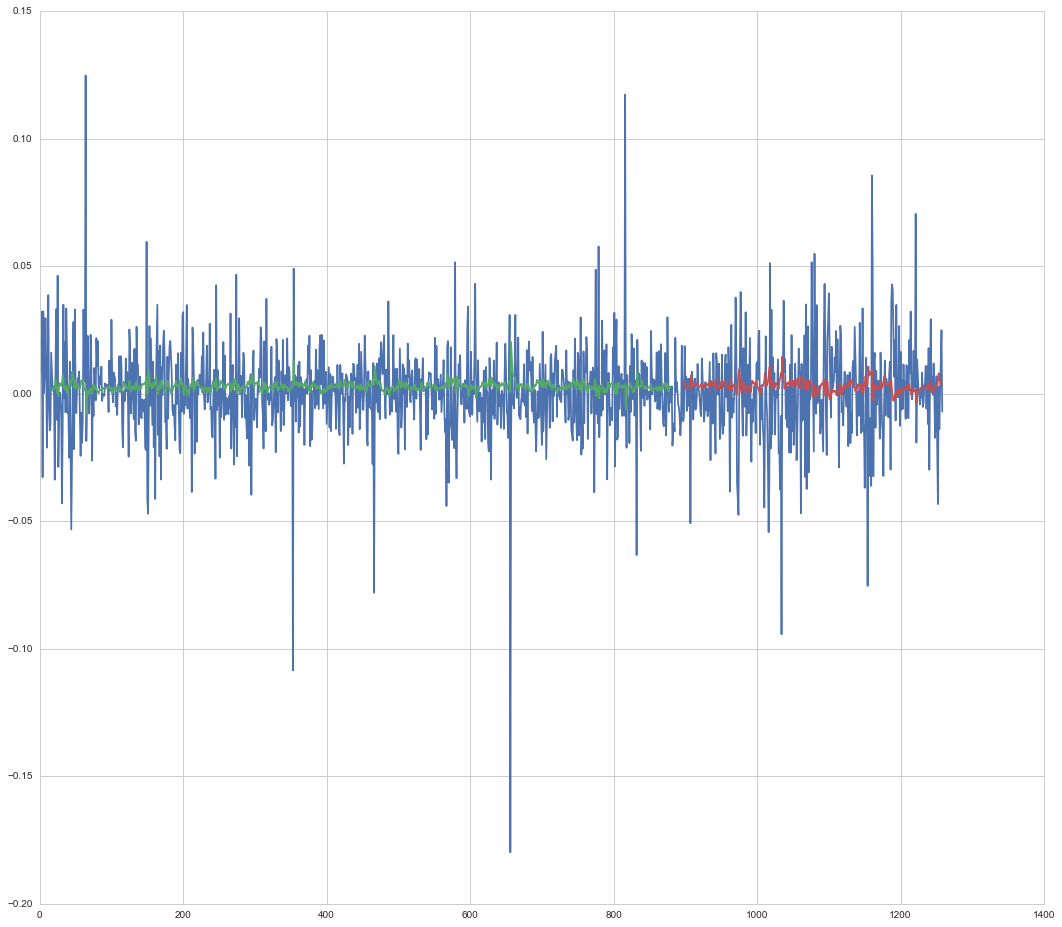

In [27]:
## According to AR, Window size= 4 
lstm_np2,lstm_tp2=LSM(dks,seed=10,look_back=17,split=0.7,n_loop=30,layer2=4,show_log = 1,batch_size = 1,cv=False)
df =pd.DataFrame(np.concatenate([lstm_np2,lstm_tp2]))
df.columns =["lstm_dks1"]
df.to_csv("output/lstm_dks1.csv", sep=',')
#Train Score: 0.01738 RMSE
#Test Score: 0.01997 RMSE

### Model2: window method with two layers

In [210]:
lstm_np3,lstm_tp3=LSTM(cab,seed=10,look_back=4,split=0.7,n_loop=30,layer2=4,show_log = 1,batch = 1,cv=False)
#Train Score: 0.02176 RMSE
#Test Score: 0.02454 RMSE
# save data
#df = pd.DataFrame([np.concatenate([lstm_np1,lstm_tp1])].reshape())
df =pd.DataFrame(np.concatenate([lstm_np3,lstm_tp3]))
df.columns =["lstm_cab2"]
df.to_csv("output/lstm_cab2.csv", sep=',')

In [211]:
lstm_np4,lstm_tp4=LSTM(dks,seed=10,look_back=17,split=0.7,n_loop=100,layer2=4,show_log = 1,batch = 1,cv=False)
#Train Score: 0.02176 RMSE
#Test Score: 0.02454 RMSE
# save data
#df = pd.DataFrame([np.concatenate([lstm_np1,lstm_tp1])].reshape())
df =pd.DataFrame(np.concatenate([lstm_np4,lstm_tp4]))
df.columns =["lstm_dks2"]
df.to_csv("output/lstm_dks2.csv", sep=',')

### Model3: window method with two layers + ICA

In [213]:
lstm_np5,lstm_tp5=LSTM_ica(cab,seed=10,look_back=10,n_component=3,layer2=5,split=0.7,n_loop=50,show_log = 1,cv=False)
df =pd.DataFrame(np.concatenate([lstm_np5,lstm_tp5]))
df.columns =["lstm_ica_cab"]
df.to_csv("output/lstm_cab3.csv", sep=',')

In [214]:
lstm_np6,lstm_tp6=LSTM_ica(dks,seed=10,look_back=17,n_component=8,layer2=5,split=0.7,n_loop=50,show_log = 1,cv=False)
df = pd.DataFrame(np.concatenate([lstm_np6,lstm_tp6]))
df.columns =["lstm_ica_dks"]
df.to_csv("output/lstm_dks3.csv", sep=',')

### Model4: Leadlag correlation with two layers + IC

In [216]:
cab_others1 = pd.read_csv("output/cabotherstweets.csv",index_col=0)[3:]
lstm_np7,lstm_tp7=LSTM_others(cab_others1,seed=10,n_features=(cab_others1.shape[1]-1),layer2=5,split=0.7,n_loop=50,show_log = 1,cv=False)
df =pd.DataFrame(np.concatenate([lstm_np7,lstm_tp7]))
df.columns =["lstm_othert_cab"]
df.to_csv("output/lstm_cab4.csv", sep=',')

In [220]:
lstm_np8,lstm_tp8=LSTM_others(dks_others1,seed=10,n_features=(dks_others1.shape[1]-1),layer2=5,split=0.7,n_loop=50,show_log = 1,cv=False)
df =pd.DataFrame(np.concatenate([lstm_np8,lstm_tp8]))
df.columns =["lstm_othert_dks"]
df.to_csv("output/lstm_dks4.csv", sep=',')

### Cross-validation process

In [202]:
## split the data into 5 parts
## if data is training and test together, we need to concate 
def cv_lstm(model,data,k_fold,split,**extraKwArgs):
    total = int(len(data) * split)
    trntotal = data[0:total]
    train_score = [0]*(k_fold-1)
    test_score = [0]*(k_fold-1)
    L = int(len(data)/k_fold)
    for i in range(1,k_fold):
        ind = i*(L+1)
        subset = data[0:ind]
        train_score[i-1],test_score[i-1] = model(dataset=subset,**extraKwArgs)
    print('Train Score: %.2f RMSE' % ((numpy.array(train_score)).mean()))
    print('Test Score: %.2f RMSE' % ((numpy.array(test_score)).mean()))

In [219]:
for size in range(1,20):
    print "Batch = "+ str(size)
    cv_lstm(LSTM,data=cab,k_fold=5,batch_size =size,n_loop=10,split=0.7,cv=True)

###  4.1 Used LSTM models

In [ ]:
# Simple model with lookback=1
# default is very simple RNN layers=[1,4,1]
def LSTM_1(trainX,trainY,testX,testY,dataset=cab,layers=[1,4,1],lookback=1,epoch=100,batch=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = dataset.values.reshape(len(dataset),1)
    trainX,trainY,testX,testY = map(np.array,(trainX,trainY,testX,testY))
    look_back=lookback
    # prepare data
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    # create and fit the LSTM network
    model = Sequential()
    layers = layers
    model.add(LSTM(layers[1], input_dim=layers[0]))
    model.add(Dense(layers[2])) #a Dense layer ( = feedforward)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, nb_epoch=epoch, batch_size=batch, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))

    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset.values)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    fig = plt.figure()
    fig.set_size_inches(18,16)
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

    return trainPredict,testPredict
## Use window method data
#trainX,trainY,testX,testY = get_wmdata(seed=7,data=cab,split=0.7,look_back=1)
#trainX,trainY,testX,testY = get_wmdata(seed=7,data=cab,split=0.7,look_back=10)
############# With default layers #############################
# First model split=0.7,epoch=100,batch_size=1
# LSM1_1_trnpred,LSM1_1_tstpred = LSTM_1(trainX,trainY,testX,testY,layers=[1,4,1],epoch=100,batch=1)
    # Train Score: 0.02 RMSE
    # Test Score: 0.02 RMSE
# Second model split=0.7,epoch=100,batch_size=2
#LSM1_2_trnpred,LSM1_2_tstpred = LSTM_1(trainX,trainY,testX,testY,layers=[1,4,1],epoch=100,batch=2)
    # Train Score: 0.02 RMSE
    # Test Score: 0.02 RMSE
# Third model split=0.7,epoch=30,batch_size=2

############# With a hidden layer of sizes 50 #################
#LSM1_3_trnpred,LSM1_3_tstpred = LSTM_1(trainX,trainY,testX,testY,layers=[1,4,1],epoch=100,batch=2)
    # Train Score: 0.02 RMSE
    # Test Score: 0.02 RMSE

############# With a window method ################# 
#LSM1_4_trnpred,LSM1_4_tstpred = LSTM_1(trainX10,trainY10,testX10,testY10,dataset=cab,layers=[10,50,1],epoch=100,batch=1)
    # Train Score: 0.02 RMSE
    # Test Score: 0.03 RMSE
    # But this one capture the small pikes
## Use window method and Ica data
# trainX10_ica3,trainY10,testX10_ica3,testY10 = wmd_ica(10, cab, split=0.7, look_back=10, n_component=3)
# LSM1_5_trnpred,LSM1_5_tstpred = LSTM_1(trainX10_ica3,trainY10,testX10_ica3,testY10,lookback=10,layers=[3,50,1],epoch=100,batch=1)
     #Train Score: 0.02 RMSE
    #Test Score: 0.02 RMSE

In [ ]:
# A model with window method and time steps
# Use the past observations them as time steps of the one input feature
# default is very simple RNN layers=[1,4,1]
def LSTM_2(trainX,trainY,testX,testY,dataset = cab, layers=[1,4,1],epoch=100,batch=1):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = dataset.values.reshape(len(dataset),1)
    trainX,trainY,testX,testY = map(np.array,(trainX,trainY,testX,testY))
    # reshape input to be [samples, time steps, features], set the columns to be the time steps dimension 
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    # create and fit the LSTM network
    model = Sequential()
    layers = layers
    look_back = layers[0]
    model.add(LSTM(layers[1], input_dim=layers[0]))
    model.add(Dense(layers[2])) #a Dense layer ( = feedforward)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, nb_epoch=epoch, batch_size=batch, verbose=2)
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset.values)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    fig = plot.figure()
    fig.set_size_inch(18,16)
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()
    
    return trainPredict,testPredict
## Use window method data
#LSM2_1_trnpred,LSM2_1_tstpred = LSTM_2(trainX,trainY,testX,testY,layers=[1,4,1],epoch=1,batch=1)
#Train Score: 0.02 RMSE
#Test Score: 0.02 RMSE
## Use window method and Ica data
#LSM2_2_trnpred,LSM2_2_tstpred = LSTM_2(trainX10_ica3,trainY10,testX10_ica3,testY10,layers=[3,50,1],epoch=100,batch=1)
#Train Score: 0.02 RMSE
#Test Score: 0.02 RMSE

## Blending model via Gradient Boosting

In [229]:
cab_predictors = pd.read_csv("output/cab_prediction.csv")
cab_trn_pred, cab_test_pred = blending(cab_predictors,0.7,learning_rate=0.1,max_depth=15,random_state=45)

In [235]:
dks_predictors = pd.read_csv("output/dks_prediction.csv")
dks_trn_pred, dks_test_pred = blending(dks_predictors,0.7,learning_rate=0.1,max_depth=15,random_state=45)